In [1]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split, cross_val_score
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline, FunctionTransformer
import types
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from lib.NaiveBayesClassifier import NaiveBayesClassifier
from sklearn.feature_selection import mutual_info_regression
from lib.Classifier import Classifier
from sklearn.preprocessing import MinMaxScaler
from functools import cache
from scipy import signal
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
np.set_printoptions(precision=6, suppress=True)

In [2]:
# pip install scikeras[tensorflow]

In [3]:
    
def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred, digits=4))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

@cache
def transform_channel_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def transform_data_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def umap_transform_channel_per_channel(array_name:str,umap):
    array = globals()[array_name]
    transform_list = []
    for channel in range(64):
        transform_list.append(umap.transform(array[:,channel,:]).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list

@cache
def transform_channel_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_channel_per_event(array_name,pca))

@cache
def transform_data_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_data_per_event(array_name,pca))

@cache
def transform_csp(array_name:str,csp):
    array = globals()[array_name]
    return csp.transform(array)

@cache
def concat_channels(array_name:str):
    array = globals()[array_name]
    list_array = []
    for event in array:
        list_array.append(np.concatenate(event))
    return np.vstack(list_array)

@cache
def transform_all_concat(array_name:str,pca):
    return pca.transform(concat_channels(array_name))

@cache
def transform_channel_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event.T)))
    transform_list = np.vstack(transform_list) 
    return transform_list

@cache
def transform_data_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event).T))
    transform_list = np.vstack(transform_list) 
    return transform_list


def create_model(my_params):
    model = tf.keras.Sequential(my_params["layers"])
    model.compile(
        optimizer=my_params["optimizer"],
        loss=my_params["loss"],
        metrics=my_params["metrics"])
    return model

def butter_bandpass(lowcut,highcut,fs,order):
    nyq=0.5*fs
    low=lowcut/nyq
    high=highcut/nyq
    b,a = signal.butter(8,[low,high],'bandpass')
    return b,a
def butter_bandpass_filter(data,lowcut,highcut,fs,order):
    b,a=butter_bandpass(lowcut,highcut,fs,order)
    y=signal.filtfilt(b,a,data,axis=2)
    return y


@cache
def transform_FBCSP(array_name:str,csps_list_name:str,freq=[4,8,12,16,20,24,28,32,36,40]):
    array = globals()[array_name]
    csps = globals()[csps_list_name]
    features_test=[]
    for freq_count in range(len(freq)):
    #loop for freqency
        lower=freq[freq_count]
        if lower==freq[-1]:
            break
        csp=csps[freq_count]
        higher=freq[freq_count+1]
        X_test_filt=butter_bandpass_filter(array,lowcut=lower,highcut=higher,fs=128,order=8)
        tmp_test=csp.transform(X_test_filt)
        if freq_count==0:
            features_test=tmp_test
        else:
            features_test=np.concatenate((features_test,tmp_test),axis=1)
    return features_test

@cache
def transform_FBCSP_channel(array_name:str,csps_list_name:str,pca,freq=[4,8,12,16,20,24,28,32,36,40]):
    csps = globals()[csps_list_name]
    array = transform_channel_per_event(array_name,pca)
    features_test=[]
    for freq_count in range(len(freq)):
    #loop for freqency
        lower=freq[freq_count]
        if lower==freq[-1]:
            break
        csp=csps[freq_count]
        higher=freq[freq_count+1]
        X_test_filt=butter_bandpass_filter(array,lowcut=lower,highcut=higher,fs=128,order=8)
        tmp_test=csp.transform(X_test_filt)
        if freq_count==0:
            features_test=tmp_test
        else:
            features_test=np.concatenate((features_test,tmp_test),axis=1)
    return features_test

class Pipe:

    def __init__(self,name, model, processed_X_train,processed_X_val, adapter = None):
        self.name = name
        self.model = model
        self.processed_X_train = processed_X_train
        self.processed_X_val = processed_X_val
        if adapter is not None:
            self.adapter = FunctionTransformer(adapter)
        else:
            self.adapter = None
        
    def create_pipeline(self):
        if self.adapter is not None:
            return Pipeline([
                ('adapter', self.adapter),
                ('model', self.model)
            ])
        else:
            return Pipeline([
                ('model', self.model)
            ])


In [4]:
subjects_range = range(1, 10)
files = [1,2
        #  ,3 # removed due to be a different test, with feedback involved. 
         ]
for subject in subjects_range:
    for file in files:
        fileName = f'../../datasources/BCICIV_2b_gdf/B{subject:02d}{file:02d}T.gdf'

        if subject == subjects_range[0] and file == files[0]:
            raw = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], verbose=0)
        else:
            new_raw = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], verbose=0)
            raw = mne.io.concatenate_raws([raw, new_raw])
            

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\1980683540.py:10: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], verbose=0)
C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\1980683540.py:12: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  new_raw = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], verbose=0)
C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\1980683540.py:12: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  new_raw = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], verbose=0)
C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\1980683540.py:12: RuntimeWarning:

In [5]:
raw_backup = raw.copy()

In [6]:
raw = raw_backup.copy()

In [7]:
names = {'EEG:C3':'C3', 'EEG:Cz':'Cz', 'EEG:C4':'C4', 'EOG:ch01':'EOG-LEFT', 'EOG:ch02':'EOG-CENTRAL', 'EOG:ch03':'EOG-RIGHT'}
raw.rename_channels(names)
raw.set_channel_types({channel:"eeg" for channel in raw.ch_names})

# Add positions to channels
mne.datasets.eegbci.standardize(raw)  # set channel names

montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage,on_missing ='warn')

raw.set_channel_types({'EOG-LEFT':'eog',
 'EOG-CENTRAL':'eog',
 'EOG-RIGHT':'eog'})

raw.annotations.rename({'769':"left", '770':"right"})

events = mne.events_from_annotations(raw)
# Apply band-pass filter
raw.filter(5.0, 42.0, fir_design="firwin", skip_by_annotation="edge")


Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', 'left', 'right']
Filtering raw data in 18 contiguous segments


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\3499692288.py:9: RuntimeWarning: DigMontage is only a subset of info. There are 3 channel positions not present in the DigMontage. The channels missing from the montage are:

['EOG-LEFT', 'EOG-CENTRAL', 'EOG-RIGHT'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage,on_missing ='warn')


Setting up band-pass filter from 5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


<RawGDF | B0101T.gdf, 6 x 11199955 (44799.8 s), ~512.7 MB, data loaded>

In [8]:
# raw.load_data()
# raw.set_eeg_reference("average")
# eog_epochs = mne.preprocessing.create_eog_epochs(raw, l_freq=5.0, h_freq=42)
# # We need to explicitly specify that we want to average the EOG channel too.
# eog_evoked = eog_epochs.average("all")

# model_evoked = mne.preprocessing.EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_evoked)
# raw_clean = model_evoked.apply(raw)

raw_clean = raw


In [9]:
raw_clean.drop_channels(['EOG-LEFT', 'EOG-CENTRAL', 'EOG-RIGHT'])
picks = mne.pick_types(raw_clean.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
tmin, tmax = -1.0, 8.0


epochs = mne.Epochs(
    raw_clean,
    event_id=[10, 11],
    events = events[0],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)


Not setting metadata
2240 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2240 events and 2251 original time points ...
0 bad epochs dropped


In [10]:


# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.

# The fixation cue start seems to be the event start, which takes 1,25 seconds. Removing 2 seconds from start for task assimilation. The event takes 6s +- 1s, to avoid adaptation, but the BCI only takes 3s.

epochs_train = epochs.copy().crop(tmin=2.0, tmax=4.0)
labels = epochs.events[:, -1] - 10

In [11]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()


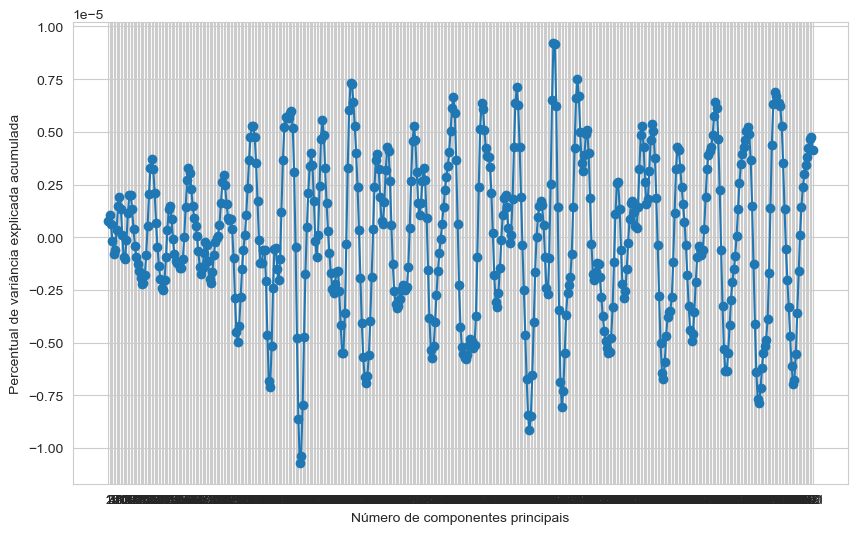

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(epochs_data_train[0][0])+1))
ax.plot(eixo_x, epochs_data_train[0][0], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Percentual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()

In [13]:
epochs_data_train.shape
# Number of events , channels, each measurement (f*t)

(2240, 3, 501)

In [14]:
list_array = []
for epoch in epochs_data_train:
    list_array.append((epoch - np.min(epoch))/(np.max(epoch)-np.min(epoch)))
epochs_data_train_normalized = np.array(list_array)

In [15]:
epochs_data_train_normalized.shape

(2240, 3, 501)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(epochs_data_train, labels, test_size=0.3,shuffle = False, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(epochs_data_train_normalized, labels, test_size=0.3,shuffle = False, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2,shuffle = False, random_state=42)


In [17]:
concat_X_train = concat_channels("X_train")

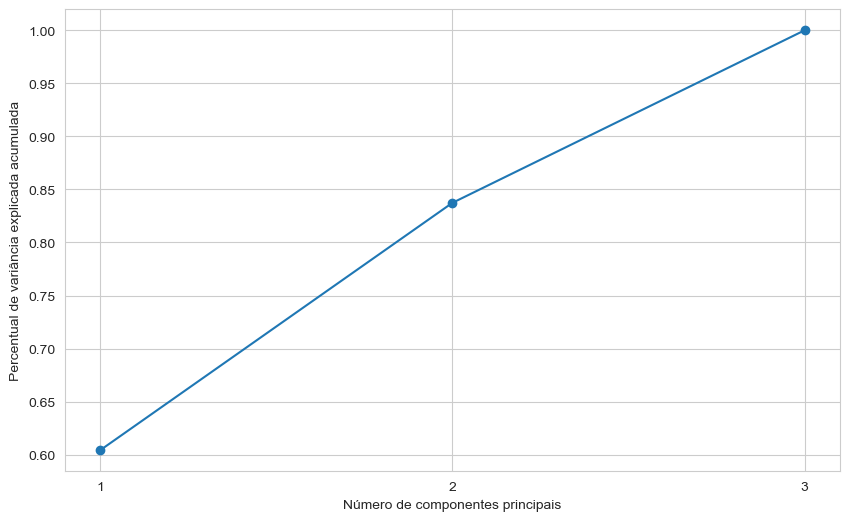

[0.604072 0.837319 1.      ] 0.8373186222139052


In [18]:
pca_channel = PCA(random_state=42,)
for event in X_train:
    pca_channel.fit(event.T)

variancia_explicada_acumulada_channel = np.cumsum(pca_channel.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Percentual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel,variancia_explicada_acumulada_channel[2-1])

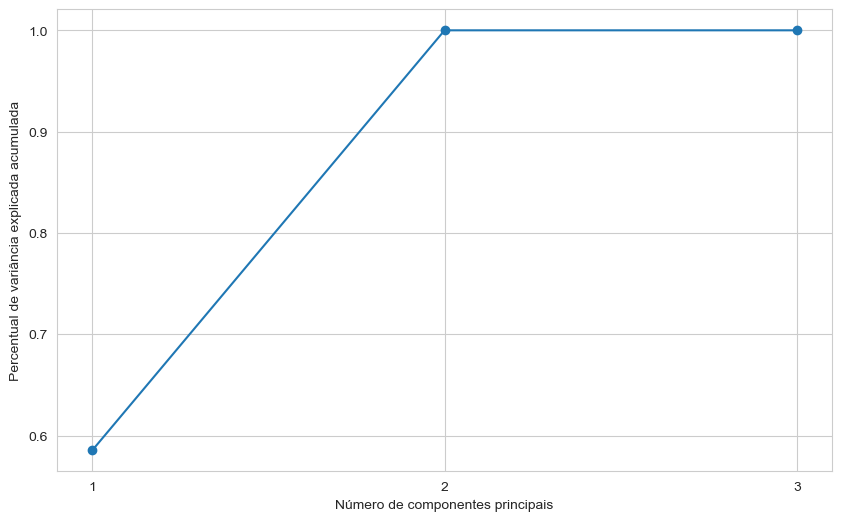

[0.585502 1.       1.      ] 1.0


In [19]:
pca_data = PCA(random_state=42,)
for event in X_train:
    pca_data.fit(event)

variancia_explicada_acumulada_data = np.cumsum(pca_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Percentual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_data,variancia_explicada_acumulada_data[2-1])

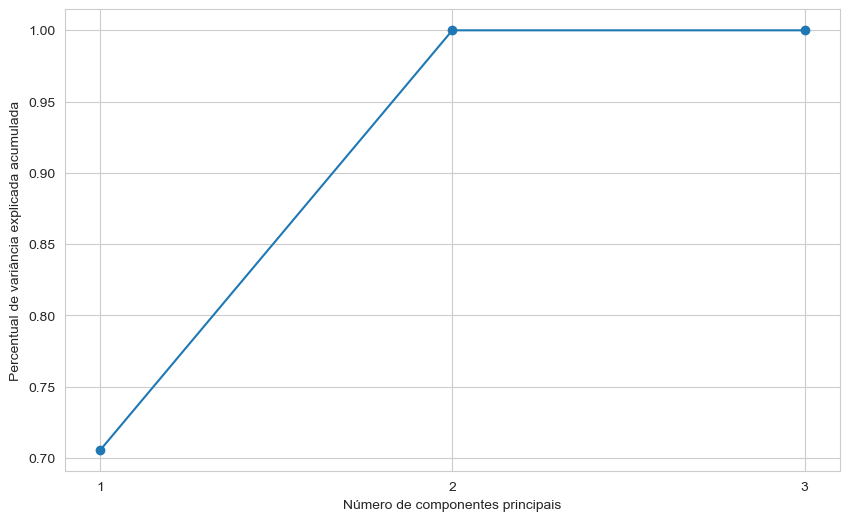

[0.70534 1.      1.     ] 1.0


In [20]:
pca_channel_data = PCA(random_state=42,)
for event in transform_channel_per_event("X_train",pca_channel):
    pca_channel_data.fit(event)

variancia_explicada_acumulada_channel_data = np.cumsum(pca_channel_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Percentual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel_data,variancia_explicada_acumulada_channel_data[2-1])

In [21]:
pca_all = PCA(random_state=42,)

pca_all.fit(concat_X_train)

PCA(random_state=42)

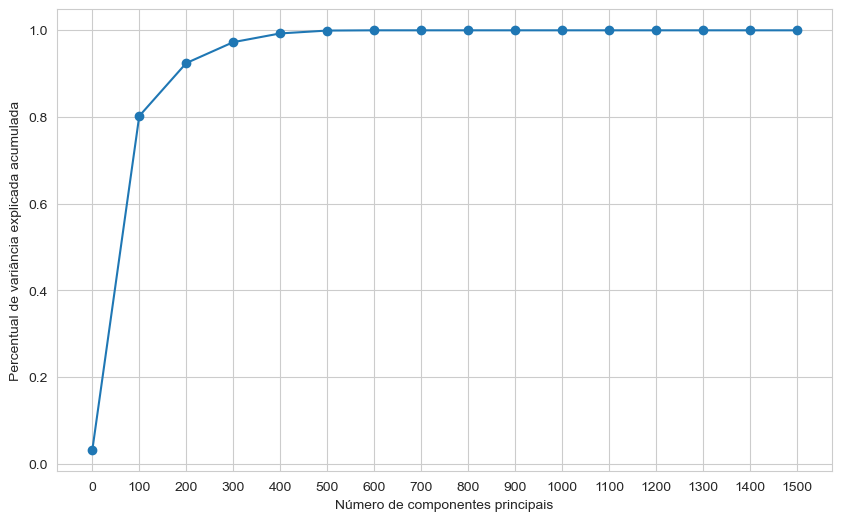

0.6759340728314547


In [22]:

variancia_explicada_acumulada_all = np.cumsum(pca_all.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(0, len(variancia_explicada_acumulada_all)+1,100))
ax.plot(eixo_x, variancia_explicada_acumulada_all[0::100], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Percentual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_all[55-1])

In [23]:
del pca_all
del pca_data
del pca_channel_data
del pca_channel


In [24]:
del variancia_explicada_acumulada_all
del variancia_explicada_acumulada_channel
del variancia_explicada_acumulada_channel_data
del variancia_explicada_acumulada_data

In [25]:
num_pca_all = 400


In [26]:
# pca900_all = PCA(random_state=42,n_components=num_pca_all)
# pca900_all.fit(concat_X_train)

In [27]:
num_csp4 = 2
num_csp15 = 3
num_pca_data = 2
num_pca_channel = 2


In [28]:
pca12_channel = PCA(random_state=42,n_components=num_pca_channel)
for event in X_train:
    pca12_channel.fit(event.T)

In [29]:
pca16_data = PCA(random_state=42,n_components=num_pca_data)
for event in X_train:
    pca16_data.fit(event)

In [30]:
X_train.shape

(1568, 3, 501)

In [31]:
csp15 = mne.decoding.CSP(n_components=num_csp15, reg=None, log=True, norm_trace=False)
csp15.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 3 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 3 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [32]:

csp4 = mne.decoding.CSP(n_components=num_csp4, reg=None, log=True, norm_trace=False)
csp4.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 3 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 3 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [33]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

features_train=[]
features_test=[]
pca12_channel_fbcsps = []
freq=[4,8,12,16,20,24,28,32,36,40]
for freq_count in range(len(freq)):
    csp=mne.decoding.CSP(n_components=2, reg=None, log=True, norm_trace=False)
    lower=freq[freq_count]
    if lower==freq[-1]:
        break
    higher=freq[freq_count+1]
    X_train_filt=butter_bandpass_filter(transform_list.T,lowcut=lower,highcut=higher,fs=128,order=8)
    csp.fit(X_train_filt,y_train)
    pca12_channel_fbcsps.append(csp)


Computing rank from data with rank=None
    Using tolerance 8.7e-07 (2.2e-16 eps * 2 dim * 2e+09  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.6e-07 (2.2e-16 eps * 2 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-07 (2.2e-16 eps * 2 dim * 9.7e+08  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 2 dim * 9.8e+08  max singular value)
    Estimated rank (m

In [34]:
features_train=[]
features_test=[]
fbcsps = []
freq=[4,8,12,16,20,24,28,32,36,40]
for freq_count in range(len(freq)):
    csp=mne.decoding.CSP(n_components=2, reg=None, log=True, norm_trace=False)
    lower=freq[freq_count]
    if lower==freq[-1]:
        break
    higher=freq[freq_count+1]
    X_train_filt=butter_bandpass_filter(X_train,lowcut=lower,highcut=higher,fs=128,order=8)
    csp.fit(X_train_filt,y_train)
    fbcsps.append(csp)

Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e-07 (2.2e-16 eps * 3 dim * 9.7e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.5e-07 (2.2e-16 eps * 3 dim * 9.8e+08  max singular value)
    Estimated rank (m

In [35]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp4 = mne.decoding.CSP(n_components=num_csp4, reg=None, log=True, norm_trace=False)
pca12_channel_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 2 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 2 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [36]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp15 = mne.decoding.CSP(n_components=num_csp15, reg=None, log=True, norm_trace=False)
pca12_channel_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 2 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 2 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [37]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp4 = mne.decoding.CSP(n_components=num_csp4, reg=None, log=True, norm_trace=False)
pca16_data_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 2.8e-07 (2.2e-16 eps * 3 dim * 4.2e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.7e-07 (2.2e-16 eps * 3 dim * 4.1e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [38]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp15 = mne.decoding.CSP(n_components=num_csp15, reg=None, log=True, norm_trace=False)
pca16_data_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 2.8e-07 (2.2e-16 eps * 3 dim * 4.2e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.7e-07 (2.2e-16 eps * 3 dim * 4.1e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [39]:
# umap15_unsup = UMAP(n_components=15,random_state=42,n_neighbors=30,min_dist=0.05)
# umap15_unsup.fit(X_train[:,0,:])

In [40]:
# umap15 = UMAP(n_components=16,random_state=42,n_neighbors=30,min_dist=0.05)
# for channel in range(64):
#     umap15.fit(X_train[:,channel,:],y_train)

In [41]:
# a = umap15.transform(X_val[:,0,:])
# fig, ax = plt.subplots()
# sns.scatterplot(ax = ax, x = a[:,0],y=  a[:,1], hue =  y_val,palette="tab10")
# ax.set_ylabel("Segunda componente")
# ax.set_xlabel("Primeira Componente")
# ax.legend(["Classe","T0","T1","T2"])
# ax.set_xticks(list(range(3, 6+1))) 
# ax.set_yticks(list(range(-2, 2+1)))
# plt.show()

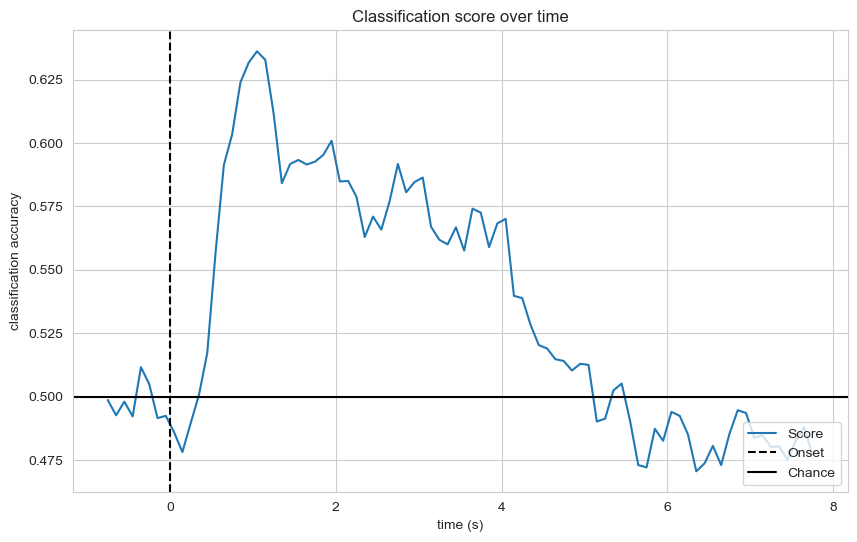

In [42]:
epochs_data_local = epochs.get_data()
epochs_data_train_local = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train_local)
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_local.shape[2] - w_length, w_step)
lda = LinearDiscriminantAnalysis()

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train_local, y_test_local = labels[train_idx], labels[test_idx]

    X_train_local = csp4.transform(epochs_data_train_local[train_idx])

    # fit classifier
    lda.fit(X_train_local, y_train_local)

cv_split = cv.split(epochs_data_train_local)

for train_idx, test_idx in cv_split:
    y_train_local, y_test_local = labels[train_idx], labels[test_idx]
    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test_local = csp4.transform(epochs_data_local[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test_local, y_test_local))
    scores_windows.append(score_this_window)


# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [43]:
import numpy as np

class Classifier:
    def __init__(self,model,FeatureSelectModel=None):
        self.model = model
        self.feature_selection = False
        self.FeatureSelectModel = FeatureSelectModel

    def predict(self,x_features):
        if self.feature_selection:
            x_features_selected = self.feature_selection.transform(x_features)
        else:
            x_features_selected = x_features
        y_predicted = self.model.predict(x_features_selected)
        return y_predicted

    def fit(self,x_features,y_train):
        feature_selection = True
        if feature_selection:
            if self.FeatureSelectModel is None:
                self.feature_selection = FeatureSelect()
            else:
                self.feature_selection = self.FeatureSelectModel
            
            x_train_features_selected = self.feature_selection.fit_transform(x_features,y_train)
        else:
            x_train_features_selected = x_features
        self.model.fit(x_train_features_selected,y_train)
        y_predicted = self.model.predict(x_train_features_selected)
        return y_predicted
    
    def score(self, x_test, y_test):
        y_predicted = self.predict(x_test)
        return accuracy_score(y_test, y_predicted)

class FeatureSelect:
    def __init__(self, n_features_select=4, n_csp_pairs=2):
        self.n_features_select = n_features_select
        self.n_csp_pairs = n_csp_pairs
        self.features_selected_indices=[]

    def fit_transform(self,x_train_features,y_train):
        MI_features = self.MIBIF(x_train_features, y_train)
        MI_sorted_idx = np.argsort(MI_features)[::-1]
        features_selected = MI_sorted_idx[:self.n_features_select]

        paired_features_idx = self.select_CSP_pairs(features_selected, self.n_csp_pairs)
        x_train_features_selected = x_train_features[:, paired_features_idx]
        self.features_selected_indices = paired_features_idx

        return x_train_features_selected

    def transform(self,x_test_features):
        return x_test_features[:,self.features_selected_indices]

    def MIBIF(self, x_features, y_labels):
        def get_prob_pw(x,d,i,h):
            n_data = d.shape[0]
            t=d[:,i]
            kernel = lambda u: np.exp(-0.5*(u**2))/np.sqrt(2*np.pi)
            prob_x = 1 / (n_data * h) * sum(kernel((np.ones((len(t)))*x- t)/h))
            return prob_x

        def get_pd_pw(d, i, x_trials):
            n_data, n_dimensions = d.shape
            if n_dimensions==1:
                i=1
            t = d[:,i]
            min_x = np.min(t)
            max_x = np.max(t)
            n_trials = x_trials.shape[0]
            std_t = np.std(t)
            if std_t==0:
                h=0.005
            else:
                h=(4./(3*n_data))**(0.2)*std_t
            prob_x = np.zeros((n_trials))
            for j in range(n_trials):
                prob_x[j] = get_prob_pw(x_trials[j],d,i,h)
            return prob_x, x_trials, h

        y_classes = np.unique(y_labels)
        n_classes = len(y_classes)
        n_trials = len(y_labels)
        prob_w = []
        x_cls = {}
        for i in range(n_classes):
            cls = y_classes[i]
            cls_indx = np.where(y_labels == cls)[0]
            prob_w.append(len(cls_indx) / n_trials)
            x_cls.update({i: x_features[cls_indx, :]})

        prob_x_w = np.zeros((n_classes, n_trials, x_features.shape[1]))
        prob_w_x = np.zeros((n_classes, n_trials, x_features.shape[1]))
        h_w_x = np.zeros((x_features.shape[1]))
        mutual_info = np.zeros((x_features.shape[1]))
        parz_win_width = 1.0 / np.log2(n_trials)
        h_w = -np.sum(prob_w * np.log2(prob_w))

        for i in range(x_features.shape[1]):
            h_w_x[i] = 0
            for j in range(n_classes):
                prob_x_w[j, :, i] = get_pd_pw(x_cls.get(j), i, x_features[:, i])[0]

        t_s = prob_x_w.shape
        n_prob_w_x = np.zeros((n_classes, t_s[1], t_s[2]))
        for i in range(n_classes):
            n_prob_w_x[i, :, :] = prob_x_w[i] * prob_w[i]
        prob_x = np.sum(n_prob_w_x, axis=0)
        # prob_w_x = np.zeros((n_classes, prob_x.shape[0], prob_w.shape[1]))
        for i in range(n_classes):
            prob_w_x[i, :, :] = n_prob_w_x[i, :, :]/prob_x

        for i in range(x_features.shape[1]):
            for j in range(n_trials):
                t_sum = 0.0
                for k in range(n_classes):
                    if prob_w_x[k, j, i] > 0:
                        t_sum += (prob_w_x[k, j, i] * np.log2(prob_w_x[k, j, i]))

                h_w_x[i] -= (t_sum / n_trials)

            mutual_info[i] = h_w - h_w_x[i]

        mifsg = np.asarray(mutual_info)
        return mifsg


    def select_CSP_pairs(self,features_selected,n_pairs):
        features_selected+=1
        sel_groups = np.unique(np.ceil(features_selected/n_pairs))
        paired_features = []
        for i in range(len(sel_groups)):
            for j in range(n_pairs-1,-1,-1):
                paired_features.append(sel_groups[i]*n_pairs-j)

        paired_features = np.asarray(paired_features,dtype=np.int)-1
        print(paired_features)
        return paired_features
        


In [45]:
# #Get Indices (it's the same for all, as suffle is False by default)
# pipe = parzen_window_mnbc_with_MIBIF_csp4 = Pipe("parzen_window_mnbc_with_MIBIF_csp4",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_csp("X_train",csp15),transform_csp("X_val",csp15))

# pipeline = pipe.create_pipeline()
# cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True,return_indices=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

# print(f"Results for pipeline with {pipe.name}:")
# print("----------------")
# print("Test accuracy scores:", cv_results['test_Accuracy'])
# print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
# print("-----")
# print("Test F1 scores:", cv_results['test_F1'])
# print("Mean test F1:", cv_results['test_F1'].mean())
# print("----------------")
# print("train accuracy scores:", cv_results['train_Accuracy'])
# print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
# print("-----")
# print("train F1 scores:", cv_results['train_F1'])
# print("Mean train F1:", cv_results['train_F1'].mean())
# print("----------------")
# print("Fit time:", cv_results['fit_time'])
# print("Score time:", cv_results['score_time'])
# print()
# print("--------------------------------------------------------------------------------------------")

# indices = cv_results["indices"]["test"]

In [46]:
def aff(array):
    X_std = (array - np.min(array)) / (np.max(array) - np.min(array))
    X_scaled = X_std * (1-0)+0
    return X_scaled

### Not runned MLP

In [47]:
# # MLP_plain = Pipe("MLP_plain",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),concat_channels("X_train")) - Takes too long
# MLP_csp4 = Pipe("MLP_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
# MLP_csp15 = Pipe("MLP_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
# MLP_pca12_channel = Pipe("MLP_pca12_channel",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# MLP_pca16_data = Pipe("MLP_pca16_data",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # # # MLP_pca900_all = Pipe("MLP_pca900_all",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
# MLP_pca12_channel_csp4 = Pipe("MLP_pca12_channel_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# MLP_pca16_data_csp4 = Pipe("MLP_pca16_data_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# MLP_pca12_channel_csp15 = Pipe("MLP_pca12_channel_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
# MLP_pca16_data_csp15 = Pipe("MLP_pca16_data_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# Keras_MLP_csp4 = Pipe("Keras_MLP_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp4).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
# Keras_MLP_csp15 = Pipe("Keras_MLP_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp15).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp15),transform_csp("X_val",csp15))

# Keras_MLP_pca12_channel = Pipe("Keras_MLP_pca12_channel",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_concat("X_train",pca12_channel).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# Keras_MLP_pca16_data = Pipe("Keras_MLP_pca16_data",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_concat("X_train",pca16_data).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # Keras_MLP_pca900_all = Pipe("Keras_MLP_pca900_all",KerasClassifier(model=create_model, my_params={
#         # "layers":[
#         #     # tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_all_concat("X_train",pca900_all).shape[1],)),
#         #     tf.keras.layers.Dense(20, activation='sigmoid'),
#         #     tf.keras.layers.Dropout(0.5,seed= 42),
#         #     tf.keras.layers.Dense(20, activation='sigmoid'),
#         #     tf.keras.layers.Dropout(0.5,seed= 42),
#         #     tf.keras.layers.Dense(10, activation='sigmoid'),
#         #     tf.keras.layers.Dense(5, activation='sigmoid'),
#         #     tf.keras.layers.Dense(3, activation='softmax')
#         # ],
#         # "optimizer":'adam',
#         # "loss": 'sparse_categorical_crossentropy',
#         # "metrics": ['accuracy']
#     # # }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))



# Keras_MLP_pca16_data_csp4 = Pipe("Keras_MLP_pca16_data_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# Keras_MLP_pca12_channel_csp4 = Pipe("Keras_MLP_pca12_channel_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# Keras_MLP_pca16_data_csp15 = Pipe("Keras_MLP_pca16_data_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# Keras_MLP_pca12_channel_csp15 = Pipe("Keras_MLP_pca12_channel_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))



### Runned Models

In [48]:
# lda_plain = Pipe("lda_csp4",LinearDiscriminantAnalysis(),concat_channels("X_train") ) - Takes too long
lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
lda_pca16_data_csp4 = Pipe("lda_pca16_data_csp4",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# lda_pca900_all = Pipe("lda_pca900_all",LinearDiscriminantAnalysis(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
lda_pca12_channel = Pipe("lda_pca12_channel",LinearDiscriminantAnalysis(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
lda_pca16_data = Pipe("lda_pca16_data",LinearDiscriminantAnalysis(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
lda_pca12_channel_csp15 = Pipe("lda_pca12_channel_csp15",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
lda_pca16_data_csp15 = Pipe("lda_pca16_data_csp15",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
lda_fbcsp_with_pca10 = Pipe("lda_fbcsp_with_pca10",Classifier(LinearDiscriminantAnalysis(),PCA(random_state=42,n_components=10)),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps"))

# mnbc_plain = Pipe("mnbc_plain",MultinomialNB(),concat_channels("X_train"),aff)
# mnbc_csp4 = Pipe("mnbc_csp4",MultinomialNB(),transform_csp("X_train",csp4),transform_csp("X_val",csp4),aff)
# mnbc_csp15 = Pipe("mnbc_csp15",MultinomialNB(),transform_csp("X_train",csp15),transform_csp("X_val",csp15),aff)
# mnbc_pca12_channel = Pipe("mnbc_pca12_channel",MultinomialNB(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel),aff)
# mnbc_pca16_data = Pipe("mnbc_pca16_data",MultinomialNB(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data),aff)
# # # # # mnbc_pca900_all = Pipe("mnbc_pca900_all",MultinomialNB(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all),aff)
# mnbc_pca12_channel_csp4 = Pipe("mnbc_pca12_channel_csp4",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4),aff)
# mnbc_pca16_data_csp4 = Pipe("mnbc_pca16_data_csp4",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4),aff)
# mnbc_pca12_channel_csp15 = Pipe("mnbc_pca12_channel_csp15",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15),aff)
# mnbc_pca16_data_csp15 = Pipe("mnbc_pca16_data_csp15",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15),aff)

parzen_window_mnbc_with_MIBIF_fbcsp = Pipe("parzen_window_mnbc_with_MIBIF_fbcsp",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
parzen_window_mnbc_with_MIBIF_csp4 = Pipe("parzen_window_mnbc_with_MIBIF_csp4",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
parzen_window_mnbc_with_MIBIF_csp15 = Pipe("parzen_window_mnbc_with_MIBIF_csp15",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
parzen_window_mnbc_with_MIBIF_pca12_channel = Pipe("parzen_window_mnbc_with_MIBIF_pca12_channel",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
parzen_window_mnbc_with_MIBIF_pca16_data = Pipe("parzen_window_mnbc_with_MIBIF_pca16_data",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
parzen_window_mnbc_with_MIBIF_pca12_channel_csp4 = Pipe("parzen_window_mnbc_with_MIBIF_pca12_channel_csp4",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
parzen_window_mnbc_with_MIBIF_pca16_data_csp4 = Pipe("parzen_window_mnbc_with_MIBIF_pca16_data_csp4",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
parzen_window_mnbc_with_MIBIF_pca12_channel_csp15 = Pipe("parzen_window_mnbc_with_MIBIF_pca12_channel_csp15",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
parzen_window_mnbc_with_MIBIF_pca16_data_csp15 = Pipe("parzen_window_mnbc_with_MIBIF_pca16_data_csp15",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))

parzen_window_mnbc_without_MIBIF_fbcsp = Pipe("parzen_window_mnbc_without_MIBIF_fbcsp",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
parzen_window_mnbc_without_MIBIF_csp4 = Pipe("parzen_window_mnbc_without_MIBIF_csp4",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
parzen_window_mnbc_without_MIBIF_csp15 = Pipe("parzen_window_mnbc_without_MIBIF_csp15",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
parzen_window_mnbc_without_MIBIF_pca12_channel = Pipe("parzen_window_mnbc_without_MIBIF_pca12_channel",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
parzen_window_mnbc_without_MIBIF_pca16_data = Pipe("parzen_window_mnbc_without_MIBIF_pca16_data",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
parzen_window_mnbc_without_MIBIF_pca12_channel_csp4 = Pipe("parzen_window_mnbc_without_MIBIF_pca12_channel_csp4",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
parzen_window_mnbc_without_MIBIF_pca16_data_csp4 = Pipe("parzen_window_mnbc_without_MIBIF_pca16_data_csp4",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
parzen_window_mnbc_without_MIBIF_pca12_channel_csp15 = Pipe("parzen_window_mnbc_without_MIBIF_pca12_channel_csp15",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
parzen_window_mnbc_without_MIBIF_pca16_data_csp15 = Pipe("parzen_window_mnbc_without_MIBIF_pca16_data_csp15",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))

parzen_window_mnbc_fbcsp_with_pca10 = Pipe("parzen_window_mnbc_fbcsp_with_pca10",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial'),PCA(random_state=42,n_components=10)),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )

svm_fbcsp = Pipe("svm_fbcsp",SVC(C=1,kernel='rbf'),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
svm_fbcsp_with_MIBIF = Pipe("svm_fbcsp",Classifier(SVC(C=1,kernel='rbf')),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
svm_csp4 = Pipe("svm_csp4",SVC(C=1,kernel='rbf'),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
svm_csp15 = Pipe("svm_csp15",SVC(C=1,kernel='rbf'),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
svm_pca12_channel_csp4 = Pipe("svm_pca12_channel_csp4",SVC(C=1,kernel='rbf'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
svm_pca16_data_csp4 = Pipe("svm_pca16_data_csp4",SVC(C=1,kernel='rbf'),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# svm_pca900_all = Pipe("svm_pca900_all",SVC(C=1,kernel='rbf'),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
svm_pca12_channel = Pipe("svm_pca12_channel",SVC(C=1,kernel='rbf'),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
svm_pca16_data = Pipe("svm_pca16_data",SVC(C=1,kernel='rbf'),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
svm_pca12_channel_csp15 = Pipe("svm_pca12_channel_csp15",SVC(C=1,kernel='rbf'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
svm_pca16_data_csp15 = Pipe("svm_pca16_data_csp15",SVC(C=1,kernel='rbf'),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
svm_fbcsp_with_pca10 = Pipe("svm_fbcsp_with_pca10",Classifier(SVC(C=1,kernel='rbf'),PCA(random_state=42,n_components=10)),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )


lda_fbcsp_with_pca10_pca12_channel = Pipe("lda_fbcsp_with_pca10_pca12_channel",Classifier(LinearDiscriminantAnalysis(),PCA(random_state=42,n_components=10)),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel))
parzen_window_mnbc_with_MIBIF_fbcsp_pca12_channel = Pipe("parzen_window_mnbc_with_MIBIF_fbcsp_pca12_channel",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )
parzen_window_mnbc_without_MIBIF_fbcsp_pca12_channel = Pipe("parzen_window_mnbc_without_MIBIF_fbcsp_pca12_channel",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )
parzen_window_mnbc_fbcsp_with_pca10_pca12_channel = Pipe("parzen_window_mnbc_fbcsp_with_pca10_pca12_channel",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial'),PCA(random_state=42,n_components=10)),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )
svm_fbcsp_pca12_channel = Pipe("svm_fbcsp_pca12_channel",SVC(C=1,kernel='rbf'),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )
svm_fbcsp_with_MIBIF_pca12_channel = Pipe("svm_fbcsp_with_MIBIF_pca12_channel",Classifier(SVC(C=1,kernel='rbf')),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )
svm_fbcsp_with_pca10_pca12_channel = Pipe("svm_fbcsp_with_pca10_pca12_channel",Classifier(SVC(C=1,kernel='rbf'),PCA(random_state=42,n_components=10)),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )

Pipes = [
    # lda_plain 
lda_fbcsp_with_pca10_pca12_channel ,
parzen_window_mnbc_with_MIBIF_fbcsp_pca12_channel ,
parzen_window_mnbc_without_MIBIF_fbcsp_pca12_channel ,
parzen_window_mnbc_fbcsp_with_pca10_pca12_channel ,
svm_fbcsp_pca12_channel ,
svm_fbcsp_with_MIBIF_pca12_channel ,
svm_fbcsp_with_pca10_pca12_channel ,
lda_csp4 ,
lda_csp15 ,
lda_pca12_channel_csp4 ,
# lda_pca16_data_csp4 ,
# lda_pca900_all ,
lda_pca12_channel ,
# lda_pca16_data ,
lda_pca12_channel_csp15 ,
# lda_pca16_data_csp15 ,
lda_fbcsp_with_pca10 ,
# mnbc_plain ,
# mnbc_csp4 ,
# mnbc_csp15 ,
# mnbc_pca12_channel ,
# mnbc_pca16_data ,
# # # # # mnbc_pca900_all ,
# mnbc_pca12_channel_csp4 ,
# mnbc_pca16_data_csp4 ,
# mnbc_pca12_channel_csp15 ,
# mnbc_pca16_data_csp15 ,
parzen_window_mnbc_with_MIBIF_fbcsp ,
# parzen_window_mnbc_with_MIBIF_csp4 ,
# parzen_window_mnbc_with_MIBIF_csp15 ,
# parzen_window_mnbc_with_MIBIF_pca12_channel ,
# parzen_window_mnbc_with_MIBIF_pca16_data ,
# parzen_window_mnbc_with_MIBIF_pca12_channel_csp4 ,
# parzen_window_mnbc_with_MIBIF_pca16_data_csp4 ,
# parzen_window_mnbc_with_MIBIF_pca12_channel_csp15 ,
# parzen_window_mnbc_with_MIBIF_pca16_data_csp15 ,
parzen_window_mnbc_without_MIBIF_fbcsp ,
parzen_window_mnbc_without_MIBIF_csp4 ,
parzen_window_mnbc_without_MIBIF_csp15 ,
parzen_window_mnbc_without_MIBIF_pca12_channel ,
# parzen_window_mnbc_without_MIBIF_pca16_data ,
parzen_window_mnbc_without_MIBIF_pca12_channel_csp4 ,
# parzen_window_mnbc_without_MIBIF_pca16_data_csp4 ,
parzen_window_mnbc_without_MIBIF_pca12_channel_csp15 ,
# parzen_window_mnbc_without_MIBIF_pca16_data_csp15 ,
parzen_window_mnbc_fbcsp_with_pca10 ,
svm_fbcsp ,
svm_fbcsp_with_MIBIF ,
svm_csp4 ,
svm_csp15 ,
svm_pca12_channel_csp4 ,
# svm_pca16_data_csp4 ,
# svm_pca900_all ,
svm_pca12_channel ,
# svm_pca16_data ,
svm_pca12_channel_csp15 ,
# svm_pca16_data_csp15 ,
svm_fbcsp_with_pca10 ,
    
    
    
]


In [49]:
results = {}
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", cv_results['test_Accuracy'])
    print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
    print("-----")
    print("Test F1 scores:", cv_results['test_F1'])
    print("Mean test F1:", cv_results['test_F1'].mean())
    print("----------------")
    print("train accuracy scores:", cv_results['train_Accuracy'])
    print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
    print("-----")
    print("train F1 scores:", cv_results['train_F1'])
    print("Mean train F1:", cv_results['train_F1'].mean())
    print("----------------")
    print("Fit time:", cv_results['fit_time'])
    print("Score time:", cv_results['score_time'])
    print()
    print("--------------------------------------------------------------------------------------------")

    results[pipe.name] = (cv_results)


lda_fbcsp_with_pca10_pca12_channel
Results for pipeline with lda_fbcsp_with_pca10_pca12_channel:
----------------
Test accuracy scores: [0.66879  0.617834 0.566879 0.515924 0.509554 0.56051  0.484076 0.579618
 0.653846 0.570513]
Mean test accuracy: 0.5727543687734771
-----
Test F1 scores: [0.663867 0.614314 0.528112 0.448206 0.506672 0.459026 0.461714 0.579191
 0.651786 0.547748]
Mean test F1: 0.5460635340815687
----------------
train accuracy scores: [0.565556 0.571935 0.5854   0.593196 0.59674  0.577605 0.589653 0.587527
 0.575071 0.597025]
Mean train accuracy: 0.5839707940242891
-----
train F1 scores: [0.5655   0.5718   0.5854   0.593191 0.596532 0.577594 0.5896   0.587525
 0.57507  0.596878]
Mean train F1: 0.5839090906340401
----------------
Fit time: [0.170325 0.032739 0.012072 0.014525 0.004997 0.021632 0.       0.015639
 0.       0.      ]
Score time: [0.008169 0.013875 0.       0.       0.001216 0.002998 0.       0.
 0.014642 0.      ]

-----------------------------------------

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 6 7]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 6 7]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 6 7]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 8 9]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 8 9]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 14 15]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 8 9]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 8 9]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]
Results for pipeline with parzen_window_mnbc_with_MIBIF_fbcsp_pca12_channel:
----------------
Test accuracy scores: [0.503185 0.496815 0.503185 0.496815 0.573248 0.656051 0.55414  0.509554
 0.717949 0.634615]
Mean test accuracy: 0.564555773313735
-----
Test F1 scores: [0.345833 0.331915 0.334746 0.342818 0.500261 0.643901 0.514233 0.359455
 0.717763 0.619594]
Mean test F1: 0.4710518997001986
----------------
train accuracy scores: [0.548547 0.554217 0.579731 0.5854   0.532955 0.554926 0.565556 0.565556
 0.554533 0.565864]
Mean train accuracy: 0.5607285331962745
-----
train F1 scores: [0.464141 0.491365 0.546491 0.567895 0.409096 0.476882 0.511337 0.496669
 0.509694 0.536571]
Mean train F1: 0.501014122094914
----------------
Fit time: [4.206677 4.359381 4.394249 4.423061 4.280129 4.219046 4.264466 4.161424
 4.241467 4.24007 ]
Score time: [0.022225 0.013979 0.015625 0.015648 0.015651 0.01563  0.015649 0.015626
 0.015623 0.015646]

-----------------------------------------------

d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: Runt

Results for pipeline with parzen_window_mnbc_without_MIBIF_fbcsp_pca12_channel:
----------------
Test accuracy scores: [0.503185 0.503185 0.496815 0.477707 0.522293 0.496815 0.503185 0.503185
 0.49359  0.487179]
Mean test accuracy: 0.4987138657520823
-----
Test F1 scores: [0.334746 0.334746 0.331915 0.323276 0.343096 0.331915 0.334746 0.334746
 0.330472 0.327586]
Mean test F1: 0.33272432443609323
----------------
train accuracy scores: [0.498228 0.498228 0.498937 0.501063 0.496102 0.498937 0.498228 0.498228
 0.499292 0.5     ]
Mean train accuracy: 0.4987243591931465
-----
train F1 scores: [0.332545 0.332545 0.332861 0.333805 0.331596 0.332861 0.332545 0.332545
 0.333018 0.333333]
Mean train F1: 0.3327654426514457
----------------
Fit time: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Score time: [0.031225 0.031253 0.031277 0.025489 0.031252 0.031294 0.031279 0.015629
 0.03338  0.031253]

--------------------------------------------------------------------------------------------
parzen_window_mnbc_

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 6 7]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 6 7]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 6 7]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 8 9]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 8 9]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 14 15]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 8 9]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 8 9]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]
Results for pipeline with svm_fbcsp_with_MIBIF_pca12_channel:
----------------
Test accuracy scores: [0.643312 0.624204 0.541401 0.458599 0.503185 0.56051  0.515924 0.617834
 0.673077 0.615385]
Mean test accuracy: 0.5753429691327779
-----
Test F1 scores: [0.619855 0.624143 0.465986 0.379677 0.499755 0.523048 0.472595 0.607892
 0.670026 0.608957]
Mean test F1: 0.5471935655159431
----------------
train accuracy scores: [0.658398 0.661942 0.678951 0.678951 0.664777 0.635011 0.662651 0.652729
 0.649433 0.623229]
Mean train accuracy: 0.6566071819355408
-----
train F1 scores: [0.654226 0.658677 0.676287 0.67833  0.664604 0.633017 0.661888 0.649892
 0.648276 0.619701]
Mean train F1: 0.654489898776606
----------------
Fit time: [4.35945  4.355726 4.335075 4.336638 4.335535 4.358125 4.343597 4.34907
 4.273457 4.263397]
Score time: [0.018487 0.01855  0.018339 0.021423 0.02174  0.025005 0.010082 0.012223
 0.016407 0.020503]

--------------------------------------------------------------

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 8 9]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 12 13]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]
Results for pipeline with parzen_window_mnbc_with_MIBIF_fbcsp:
----------------
Test accuracy scores: [0.598726 0.535032 0.547771 0.528662 0.55414  0.713376 0.55414  0.541401
 0.724359 0.647436]
Mean test accuracy: 0.5945043279438185
-----
Test F1 scores: [0.524585 0.435224 0.528169 0.528643 0.474866 0.71319  0.447405 0.439286
 0.723803 0.64497 ]
Mean test F1: 0.5460142303094295
----------------
train accuracy scores: [0.60241  0.626506 0.638554 0.649185 0.569809 0.619419 0.613749 0.616584
 0.628187 0.638102]
Mean train accuracy: 0.6202504401876795
-----
train F1 scores: [0.549885 0.589816 0.621322 0.648956 0.470125 0.602146 0.567367 0.574024
 0.622912 0.635852]
Mean train F1: 0.5882405341661148
----------------
Fit time: [4.222834 4.202706 4.183051 4.201231 4.375202 4.198175 4.224423 4.192902
 4.229435 4.330873]
Score time: [0.002056 0.021048 0.015625 0.015689 0.015651 0.015625 0.011606 0.031251
 0.018826 0.004573]

-----------------------------------------------------------

d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: Runt

Results for pipeline with parzen_window_mnbc_without_MIBIF_fbcsp:
----------------
Test accuracy scores: [0.503185 0.503185 0.496815 0.477707 0.522293 0.496815 0.503185 0.503185
 0.49359  0.487179]
Mean test accuracy: 0.4987138657520823
-----
Test F1 scores: [0.334746 0.334746 0.331915 0.323276 0.343096 0.331915 0.334746 0.334746
 0.330472 0.327586]
Mean test F1: 0.33272432443609323
----------------
train accuracy scores: [0.498228 0.498228 0.498937 0.501063 0.496102 0.498937 0.498228 0.498228
 0.499292 0.5     ]
Mean train accuracy: 0.4987243591931465
-----
train F1 scores: [0.332545 0.332545 0.332861 0.333805 0.331596 0.332861 0.332545 0.332545
 0.333018 0.333333]
Mean train F1: 0.3327654426514457
----------------
Fit time: [0.       0.       0.000999 0.000976 0.       0.       0.       0.001
 0.000973 0.      ]
Score time: [0.029354 0.018728 0.029118 0.029995 0.015651 0.025011 0.025778 0.029114
 0.030213 0.031667]

--------------------------------------------------------------------

d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return summation / (N * (h ** dim))
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return summation / (N * (h ** dim))
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return summation / (N * (h ** dim))
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return summation / (N * (h ** dim))
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeW

Results for pipeline with parzen_window_mnbc_without_MIBIF_pca12_channel:
----------------
Test accuracy scores: [0.503185 0.503185 0.496815 0.477707 0.522293 0.496815 0.503185 0.503185
 0.49359  0.487179]
Mean test accuracy: 0.4987138657520823
-----
Test F1 scores: [0.334746 0.334746 0.331915 0.323276 0.343096 0.331915 0.334746 0.334746
 0.330472 0.327586]
Mean test F1: 0.33272432443609323
----------------
train accuracy scores: [0.498228 0.498228 0.498937 0.501063 0.496102 0.498937 0.498228 0.498228
 0.499292 0.5     ]
Mean train accuracy: 0.4987243591931465
-----
train F1 scores: [0.332545 0.332545 0.332861 0.333805 0.331596 0.332861 0.332545 0.332545
 0.333018 0.333333]
Mean train F1: 0.3327654426514457
----------------
Fit time: [0.       0.015649 0.003705 0.000429 0.002998 0.003001 0.008275 0.004117
 0.       0.015649]
Score time: [3.09923  2.958205 2.908293 3.15386  2.759429 2.807023 2.86035  3.043497
 2.893185 2.768704]

---------------------------------------------------------

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 8 9]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 12 13]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]
Results for pipeline with svm_fbcsp:
----------------
Test accuracy scores: [0.770701 0.624204 0.55414  0.477707 0.636943 0.707006 0.566879 0.611465
 0.679487 0.615385]
Mean test accuracy: 0.6243916380859057
-----
Test F1 scores: [0.770468 0.615212 0.554122 0.476667 0.633132 0.705561 0.501121 0.608351
 0.678165 0.608957]
Mean test F1: 0.6151756193924462
----------------
train accuracy scores: [0.642098 0.661942 0.669738 0.675408 0.664068 0.649185 0.664068 0.699504
 0.674221 0.667847]
Mean train accuracy: 0.6668077910709661
-----
train F1 scores: [0.639577 0.658957 0.668297 0.674536 0.662406 0.648506 0.663629 0.698865
 0.673418 0.666804]
Mean train F1: 0.6654995639189247
----------------
Fit time: [4.193285 4.179879 4.199878 4.207414 4.254073 4.263754 4.229341 4.27304
 4.264714 4.288151]
Score time: [0.016502 0.041651 0.020957 0.021431 0.01076  0.023073 0.028798 0.019336
 0.020879 0.021206]

--------------------------------------------------------------------------------------

In [50]:
for key, value in results.items(): 
    print(value['test_Accuracy'])
    print(",")
for key, value in results.items(): 
    print(np.mean(value['test_Accuracy']))
    print(",")
for key, value in results.items(): 
    print(np.max(value['test_Accuracy']))
    print(",")
for key, value in results.items(): 
    print(value['test_F1'])
    print(",")
for key, value in results.items(): 
    print(value['train_Accuracy'])
    print(",")
for key, value in results.items(): 
    print(np.mean(value['train_Accuracy']))
    print(",")
for key, value in results.items(): 
    print(np.max(value['train_Accuracy']))
    print(",")
for key, value in results.items(): 
    print(value['train_F1'])
    print(",")
for key, value in results.items(): 
    print(value['fit_time'])
    print(",")
for key, value in results.items(): 
    print(value['score_time'])
    print(",")

[0.66879  0.617834 0.566879 0.515924 0.509554 0.56051  0.484076 0.579618
 0.653846 0.570513]
,
[0.503185 0.496815 0.503185 0.496815 0.573248 0.656051 0.55414  0.509554
 0.717949 0.634615]
,
[0.503185 0.503185 0.496815 0.477707 0.522293 0.496815 0.503185 0.503185
 0.49359  0.487179]
,
[0.605096 0.528662 0.515924 0.509554 0.477707 0.598726 0.579618 0.547771
 0.570513 0.538462]
,
[0.636943 0.598726 0.503185 0.477707 0.547771 0.66879  0.55414  0.56051
 0.628205 0.615385]
,
[0.643312 0.624204 0.541401 0.458599 0.503185 0.56051  0.515924 0.617834
 0.673077 0.615385]
,
[0.636943 0.624204 0.528662 0.490446 0.535032 0.617834 0.515924 0.528662
 0.576923 0.576923]
,
[0.675159 0.579618 0.55414  0.515924 0.592357 0.624204 0.55414  0.66242
 0.692308 0.602564]
,
[0.681529 0.579618 0.56051  0.509554 0.605096 0.617834 0.55414  0.649682
 0.673077 0.576923]
,
[0.732484 0.573248 0.496815 0.484076 0.490446 0.535032 0.509554 0.66242
 0.660256 0.608974]
,
[0.471338 0.509554 0.515924 0.496815 0.426752 0.47133

In [51]:
# # lda_plain = Pipe("lda_csp4",LinearDiscriminantAnalysis(),concat_channels("X_train") ) - Takes too long
# lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
# lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
# lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# lda_pca16_data_csp4 = Pipe("lda_pca16_data_csp4",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# # lda_pca900_all = Pipe("lda_pca900_all",LinearDiscriminantAnalysis(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
# lda_pca12_channel = Pipe("lda_pca12_channel",LinearDiscriminantAnalysis(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# lda_pca16_data = Pipe("lda_pca16_data",LinearDiscriminantAnalysis(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# lda_pca12_channel_csp15 = Pipe("lda_pca12_channel_csp15",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
# lda_pca16_data_csp15 = Pipe("lda_pca16_data_csp15",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# lda_fbcsp_with_pca10 = Pipe("lda_fbcsp_with_pca10",Classifier(LinearDiscriminantAnalysis(),PCA(random_state=42,n_components=10)),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps"))

# # mnbc_plain = Pipe("mnbc_plain",MultinomialNB(),concat_channels("X_train"),aff)
# # mnbc_csp4 = Pipe("mnbc_csp4",MultinomialNB(),transform_csp("X_train",csp4),transform_csp("X_val",csp4),aff)
# # mnbc_csp15 = Pipe("mnbc_csp15",MultinomialNB(),transform_csp("X_train",csp15),transform_csp("X_val",csp15),aff)
# # mnbc_pca12_channel = Pipe("mnbc_pca12_channel",MultinomialNB(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel),aff)
# # mnbc_pca16_data = Pipe("mnbc_pca16_data",MultinomialNB(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data),aff)
# # # # # # mnbc_pca900_all = Pipe("mnbc_pca900_all",MultinomialNB(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all),aff)
# # mnbc_pca12_channel_csp4 = Pipe("mnbc_pca12_channel_csp4",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4),aff)
# # mnbc_pca16_data_csp4 = Pipe("mnbc_pca16_data_csp4",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4),aff)
# # mnbc_pca12_channel_csp15 = Pipe("mnbc_pca12_channel_csp15",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15),aff)
# # mnbc_pca16_data_csp15 = Pipe("mnbc_pca16_data_csp15",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15),aff)

# parzen_window_mnbc_with_MIBIF_fbcsp = Pipe("parzen_window_mnbc_with_MIBIF_fbcsp",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
# parzen_window_mnbc_with_MIBIF_csp4 = Pipe("parzen_window_mnbc_with_MIBIF_csp4",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
# parzen_window_mnbc_with_MIBIF_csp15 = Pipe("parzen_window_mnbc_with_MIBIF_csp15",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
# parzen_window_mnbc_with_MIBIF_pca12_channel = Pipe("parzen_window_mnbc_with_MIBIF_pca12_channel",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# parzen_window_mnbc_with_MIBIF_pca16_data = Pipe("parzen_window_mnbc_with_MIBIF_pca16_data",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# parzen_window_mnbc_with_MIBIF_pca12_channel_csp4 = Pipe("parzen_window_mnbc_with_MIBIF_pca12_channel_csp4",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# parzen_window_mnbc_with_MIBIF_pca16_data_csp4 = Pipe("parzen_window_mnbc_with_MIBIF_pca16_data_csp4",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# parzen_window_mnbc_with_MIBIF_pca12_channel_csp15 = Pipe("parzen_window_mnbc_with_MIBIF_pca12_channel_csp15",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
# parzen_window_mnbc_with_MIBIF_pca16_data_csp15 = Pipe("parzen_window_mnbc_with_MIBIF_pca16_data_csp15",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))

# parzen_window_mnbc_without_MIBIF_fbcsp = Pipe("parzen_window_mnbc_without_MIBIF_fbcsp",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
# parzen_window_mnbc_without_MIBIF_csp4 = Pipe("parzen_window_mnbc_without_MIBIF_csp4",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
# parzen_window_mnbc_without_MIBIF_csp15 = Pipe("parzen_window_mnbc_without_MIBIF_csp15",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
# parzen_window_mnbc_without_MIBIF_pca12_channel = Pipe("parzen_window_mnbc_without_MIBIF_pca12_channel",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# parzen_window_mnbc_without_MIBIF_pca16_data = Pipe("parzen_window_mnbc_without_MIBIF_pca16_data",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# parzen_window_mnbc_without_MIBIF_pca12_channel_csp4 = Pipe("parzen_window_mnbc_without_MIBIF_pca12_channel_csp4",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# parzen_window_mnbc_without_MIBIF_pca16_data_csp4 = Pipe("parzen_window_mnbc_without_MIBIF_pca16_data_csp4",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# parzen_window_mnbc_without_MIBIF_pca12_channel_csp15 = Pipe("parzen_window_mnbc_without_MIBIF_pca12_channel_csp15",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
# parzen_window_mnbc_without_MIBIF_pca16_data_csp15 = Pipe("parzen_window_mnbc_without_MIBIF_pca16_data_csp15",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))

# parzen_window_mnbc_fbcsp_with_pca10 = Pipe("parzen_window_mnbc_fbcsp_with_pca10",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial'),PCA(random_state=42,n_components=10)),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )

# svm_fbcsp = Pipe("svm_fbcsp",SVC(C=1,kernel='rbf'),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
# svm_fbcsp_with_MIBIF = Pipe("svm_fbcsp",Classifier(SVC(C=1,kernel='rbf')),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
# svm_csp4 = Pipe("svm_csp4",SVC(C=1,kernel='rbf'),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
# svm_csp15 = Pipe("svm_csp15",SVC(C=1,kernel='rbf'),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
# svm_pca12_channel_csp4 = Pipe("svm_pca12_channel_csp4",SVC(C=1,kernel='rbf'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# svm_pca16_data_csp4 = Pipe("svm_pca16_data_csp4",SVC(C=1,kernel='rbf'),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# # svm_pca900_all = Pipe("svm_pca900_all",SVC(C=1,kernel='rbf'),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
# svm_pca12_channel = Pipe("svm_pca12_channel",SVC(C=1,kernel='rbf'),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# svm_pca16_data = Pipe("svm_pca16_data",SVC(C=1,kernel='rbf'),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# svm_pca12_channel_csp15 = Pipe("svm_pca12_channel_csp15",SVC(C=1,kernel='rbf'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
# svm_pca16_data_csp15 = Pipe("svm_pca16_data_csp15",SVC(C=1,kernel='rbf'),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# svm_fbcsp_with_pca10 = Pipe("svm_fbcsp_with_pca10",Classifier(SVC(C=1,kernel='rbf'),PCA(random_state=42,n_components=10)),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )


# lda_fbcsp_with_pca10_pca12_channel = Pipe("lda_fbcsp_with_pca10_pca12_channel",Classifier(LinearDiscriminantAnalysis(),PCA(random_state=42,n_components=10)),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel))
# parzen_window_mnbc_with_MIBIF_fbcsp_pca12_channel = Pipe("parzen_window_mnbc_with_MIBIF_fbcsp_pca12_channel",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )
# parzen_window_mnbc_without_MIBIF_fbcsp_pca12_channel = Pipe("parzen_window_mnbc_without_MIBIF_fbcsp_pca12_channel",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )
# parzen_window_mnbc_fbcsp_with_pca10_pca12_channel = Pipe("parzen_window_mnbc_fbcsp_with_pca10_pca12_channel",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial'),PCA(random_state=42,n_components=10)),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )
# svm_fbcsp_pca12_channel = Pipe("svm_fbcsp_pca12_channel",SVC(C=1,kernel='rbf'),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )
# svm_fbcsp_with_MIBIF_pca12_channel = Pipe("svm_fbcsp_with_MIBIF_pca12_channel",Classifier(SVC(C=1,kernel='rbf')),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )
# svm_fbcsp_with_pca10_pca12_channel = Pipe("svm_fbcsp_with_pca10_pca12_channel",Classifier(SVC(C=1,kernel='rbf'),PCA(random_state=42,n_components=10)),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )

# Pipes = [
#     # lda_plain 
# lda_fbcsp_with_pca10_pca12_channel ,
# parzen_window_mnbc_with_MIBIF_fbcsp_pca12_channel ,
# parzen_window_mnbc_without_MIBIF_fbcsp_pca12_channel ,
# parzen_window_mnbc_fbcsp_with_pca10_pca12_channel ,
# svm_fbcsp_pca12_channel ,
# svm_fbcsp_with_MIBIF_pca12_channel ,
# svm_fbcsp_with_pca10_pca12_channel ,
# lda_csp4 ,
# lda_csp15 ,
# lda_pca12_channel_csp4 ,
# # lda_pca16_data_csp4 ,
# # lda_pca900_all ,
# lda_pca12_channel ,
# # lda_pca16_data ,
# lda_pca12_channel_csp15 ,
# # lda_pca16_data_csp15 ,
# lda_fbcsp_with_pca10 ,
# # mnbc_plain ,
# # mnbc_csp4 ,
# # mnbc_csp15 ,
# # mnbc_pca12_channel ,
# # mnbc_pca16_data ,
# # # # # # mnbc_pca900_all ,
# # mnbc_pca12_channel_csp4 ,
# # mnbc_pca16_data_csp4 ,
# # mnbc_pca12_channel_csp15 ,
# # mnbc_pca16_data_csp15 ,
# parzen_window_mnbc_with_MIBIF_fbcsp ,
# # parzen_window_mnbc_with_MIBIF_csp4 ,
# # parzen_window_mnbc_with_MIBIF_csp15 ,
# # parzen_window_mnbc_with_MIBIF_pca12_channel ,
# # parzen_window_mnbc_with_MIBIF_pca16_data ,
# # parzen_window_mnbc_with_MIBIF_pca12_channel_csp4 ,
# # parzen_window_mnbc_with_MIBIF_pca16_data_csp4 ,
# # parzen_window_mnbc_with_MIBIF_pca12_channel_csp15 ,
# # parzen_window_mnbc_with_MIBIF_pca16_data_csp15 ,
# parzen_window_mnbc_without_MIBIF_fbcsp ,
# parzen_window_mnbc_without_MIBIF_csp4 ,
# parzen_window_mnbc_without_MIBIF_csp15 ,
# parzen_window_mnbc_without_MIBIF_pca12_channel ,
# # parzen_window_mnbc_without_MIBIF_pca16_data ,
# parzen_window_mnbc_without_MIBIF_pca12_channel_csp4 ,
# # parzen_window_mnbc_without_MIBIF_pca16_data_csp4 ,
# parzen_window_mnbc_without_MIBIF_pca12_channel_csp15 ,
# # parzen_window_mnbc_without_MIBIF_pca16_data_csp15 ,
# parzen_window_mnbc_fbcsp_with_pca10 ,
# svm_fbcsp ,
# svm_fbcsp_with_MIBIF ,
# svm_csp4 ,
# svm_csp15 ,
# svm_pca12_channel_csp4 ,
# # svm_pca16_data_csp4 ,
# # svm_pca900_all ,
# svm_pca12_channel ,
# # svm_pca16_data ,
# svm_pca12_channel_csp15 ,
# # svm_pca16_data_csp15 ,
# svm_fbcsp_with_pca10 ,
    
    
    
# ]


In [52]:
results_val = {}
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    pipeline.fit( pipe.processed_X_train, y_train)
    train_score = pipeline.score(pipe.processed_X_train,y_train)
    val_score = pipeline.score(pipe.processed_X_val,y_val)


    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", val_score)
    print("----------------")
    print("train accuracy scores:", train_score)
    print()
    print("--------------------------------------------------------------------------------------------")

    results_val[pipe.name] = (pipeline)


lda_fbcsp_with_pca10_pca12_channel
Results for pipeline with lda_fbcsp_with_pca10_pca12_channel:
----------------
Test accuracy scores: 0.5491071428571429
----------------
train accuracy scores: 0.5829081632653061

--------------------------------------------------------------------------------------------
parzen_window_mnbc_with_MIBIF_fbcsp_pca12_channel


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 8 9]
Results for pipeline with parzen_window_mnbc_with_MIBIF_fbcsp_pca12_channel:
----------------
Test accuracy scores: 0.5252976190476191
----------------
train accuracy scores: 0.5733418367346939

--------------------------------------------------------------------------------------------
parzen_window_mnbc_without_MIBIF_fbcsp_pca12_channel


d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))


Results for pipeline with parzen_window_mnbc_without_MIBIF_fbcsp_pca12_channel:
----------------
Test accuracy scores: 0.5029761904761905
----------------
train accuracy scores: 0.4987244897959184

--------------------------------------------------------------------------------------------
parzen_window_mnbc_fbcsp_with_pca10_pca12_channel
Results for pipeline with parzen_window_mnbc_fbcsp_with_pca10_pca12_channel:
----------------
Test accuracy scores: 0.5223214285714286
----------------
train accuracy scores: 0.5746173469387755

--------------------------------------------------------------------------------------------
svm_fbcsp_pca12_channel
Results for pipeline with svm_fbcsp_pca12_channel:
----------------
Test accuracy scores: 0.5431547619047619
----------------
train accuracy scores: 0.6926020408163265

--------------------------------------------------------------------------------------------
svm_fbcsp_with_MIBIF_pca12_channel


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5 8 9]
Results for pipeline with svm_fbcsp_with_MIBIF_pca12_channel:
----------------
Test accuracy scores: 0.5431547619047619
----------------
train accuracy scores: 0.65625

--------------------------------------------------------------------------------------------
svm_fbcsp_with_pca10_pca12_channel
Results for pipeline with svm_fbcsp_with_pca10_pca12_channel:
----------------
Test accuracy scores: 0.5193452380952381
----------------
train accuracy scores: 0.6511479591836735

--------------------------------------------------------------------------------------------
lda_csp4
Results for pipeline with lda_csp4:
----------------
Test accuracy scores: 0.5372023809523809
----------------
train accuracy scores: 0.6116071428571429

--------------------------------------------------------------------------------------------
lda_csp15
Results for pipeline with lda_csp15:
----------------
Test accuracy scores: 0.5357142857142857
----------------
train accuracy scores: 0.6084183673469

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]
Results for pipeline with parzen_window_mnbc_with_MIBIF_fbcsp:
----------------
Test accuracy scores: 0.5476190476190477
----------------
train accuracy scores: 0.6205357142857143

--------------------------------------------------------------------------------------------
parzen_window_mnbc_without_MIBIF_fbcsp


d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))


Results for pipeline with parzen_window_mnbc_without_MIBIF_fbcsp:
----------------
Test accuracy scores: 0.5029761904761905
----------------
train accuracy scores: 0.4987244897959184

--------------------------------------------------------------------------------------------
parzen_window_mnbc_without_MIBIF_csp4
Results for pipeline with parzen_window_mnbc_without_MIBIF_csp4:
----------------
Test accuracy scores: 0.5252976190476191
----------------
train accuracy scores: 0.5605867346938775

--------------------------------------------------------------------------------------------
parzen_window_mnbc_without_MIBIF_csp15
Results for pipeline with parzen_window_mnbc_without_MIBIF_csp15:
----------------
Test accuracy scores: 0.5029761904761905
----------------
train accuracy scores: 0.5318877551020408

--------------------------------------------------------------------------------------------
parzen_window_mnbc_without_MIBIF_pca12_channel


d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return summation / (N * (h ** dim))


Results for pipeline with parzen_window_mnbc_without_MIBIF_pca12_channel:
----------------
Test accuracy scores: 0.5029761904761905
----------------
train accuracy scores: 0.4987244897959184

--------------------------------------------------------------------------------------------
parzen_window_mnbc_without_MIBIF_pca12_channel_csp4
Results for pipeline with parzen_window_mnbc_without_MIBIF_pca12_channel_csp4:
----------------
Test accuracy scores: 0.5029761904761905
----------------
train accuracy scores: 0.5197704081632653

--------------------------------------------------------------------------------------------
parzen_window_mnbc_without_MIBIF_pca12_channel_csp15
Results for pipeline with parzen_window_mnbc_without_MIBIF_pca12_channel_csp15:
----------------
Test accuracy scores: 0.5029761904761905
----------------
train accuracy scores: 0.5197704081632653

--------------------------------------------------------------------------------------------
parzen_window_mnbc_fbcsp_with

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_25036\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 4 5]
Results for pipeline with svm_fbcsp:
----------------
Test accuracy scores: 0.5714285714285714
----------------
train accuracy scores: 0.6568877551020408

--------------------------------------------------------------------------------------------
svm_csp4
Results for pipeline with svm_csp4:
----------------
Test accuracy scores: 0.5223214285714286
----------------
train accuracy scores: 0.6154336734693877

--------------------------------------------------------------------------------------------
svm_csp15
Results for pipeline with svm_csp15:
----------------
Test accuracy scores: 0.5342261904761905
----------------
train accuracy scores: 0.6403061224489796

--------------------------------------------------------------------------------------------
svm_pca12_channel_csp4
Results for pipeline with svm_pca12_channel_csp4:
----------------
Test accuracy scores: 0.5401785714285714
----------------
train accuracy scores: 0.6090561224489796

-------------------------------------

lda_fbcsp_with_pca10_pca12_channel
              precision    recall  f1-score   support

           0     0.5526    0.5444    0.5484       338
           1     0.5457    0.5539    0.5498       334

    accuracy                         0.5491       672
   macro avg     0.5491    0.5491    0.5491       672
weighted avg     0.5492    0.5491    0.5491       672



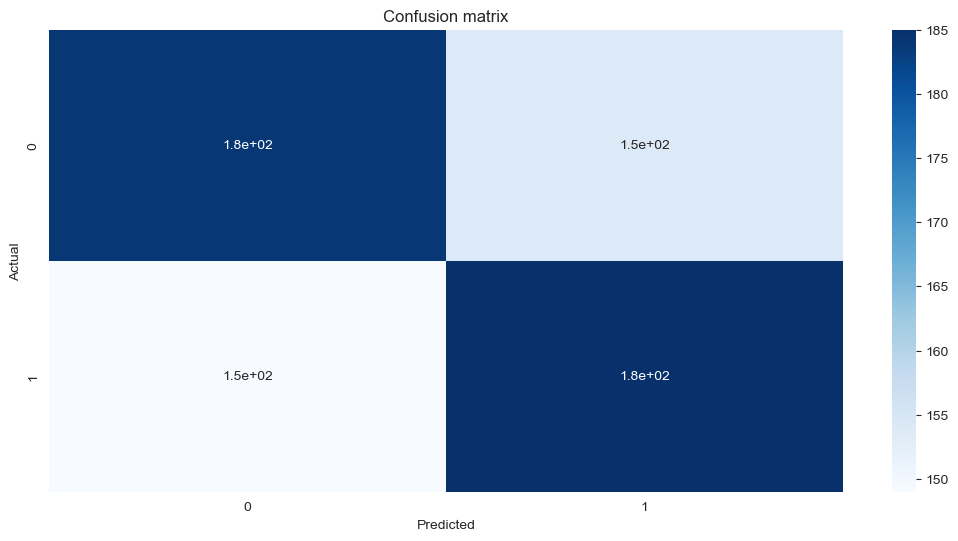

parzen_window_mnbc_with_MIBIF_fbcsp_pca12_channel
              precision    recall  f1-score   support

           0     0.6092    0.1568    0.2494       338
           1     0.5128    0.8982    0.6529       334

    accuracy                         0.5253       672
   macro avg     0.5610    0.5275    0.4511       672
weighted avg     0.5613    0.5253    0.4499       672



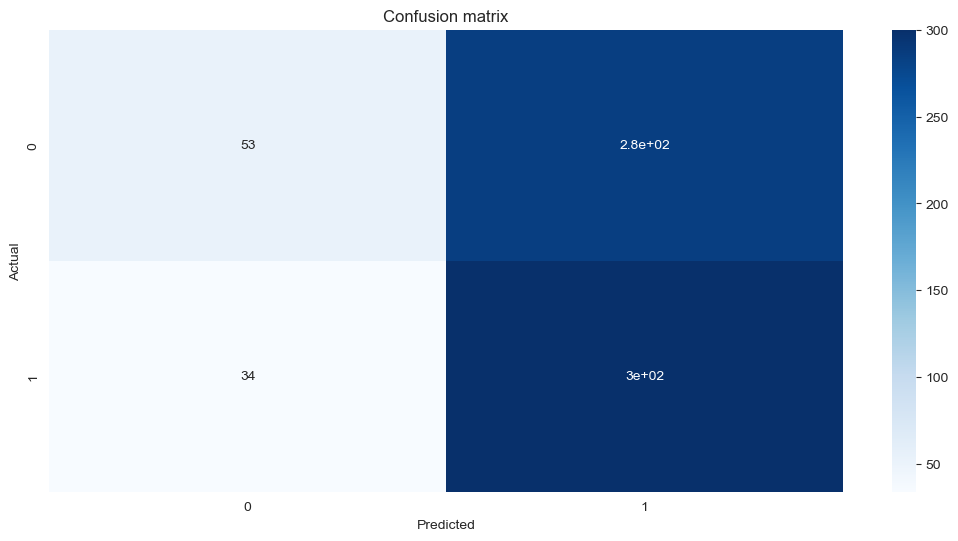

parzen_window_mnbc_without_MIBIF_fbcsp_pca12_channel
              precision    recall  f1-score   support

           0     0.5030    1.0000    0.6693       338
           1     0.0000    0.0000    0.0000       334

    accuracy                         0.5030       672
   macro avg     0.2515    0.5000    0.3347       672
weighted avg     0.2530    0.5030    0.3366       672



d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defi

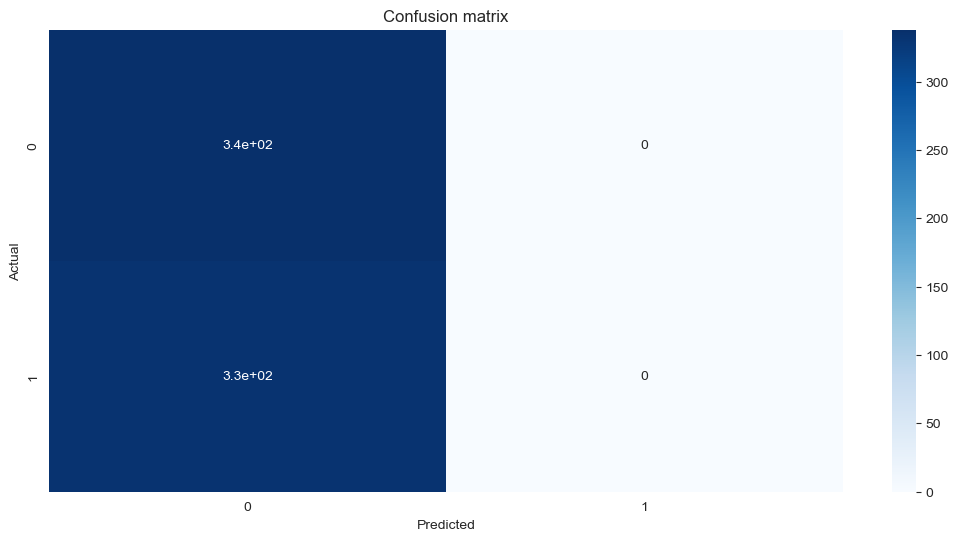

parzen_window_mnbc_fbcsp_with_pca10_pca12_channel
              precision    recall  f1-score   support

           0     0.5356    0.3787    0.4437       338
           1     0.5150    0.6677    0.5815       334

    accuracy                         0.5223       672
   macro avg     0.5253    0.5232    0.5126       672
weighted avg     0.5253    0.5223    0.5122       672



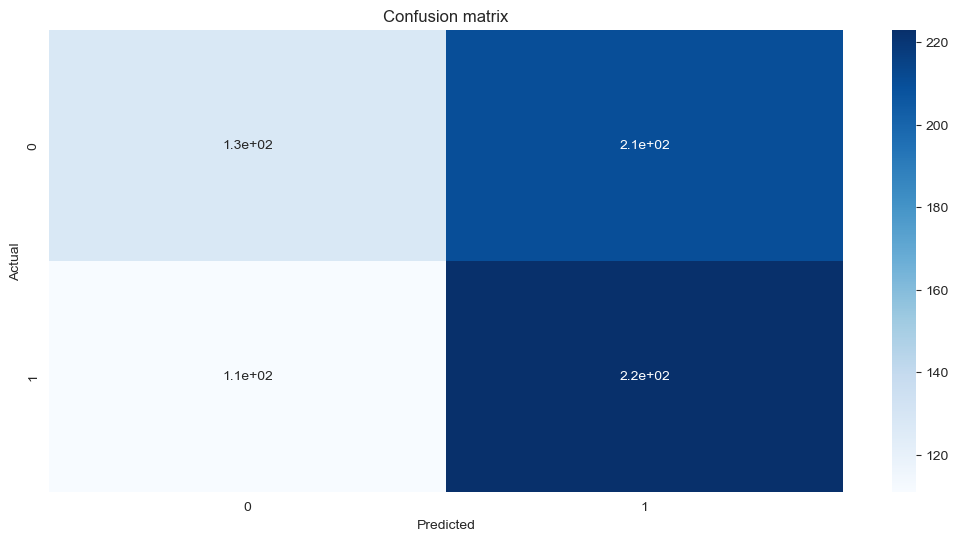

svm_fbcsp_pca12_channel
              precision    recall  f1-score   support

           0     0.5518    0.4882    0.5181       338
           1     0.5362    0.5988    0.5658       334

    accuracy                         0.5432       672
   macro avg     0.5440    0.5435    0.5419       672
weighted avg     0.5441    0.5432    0.5418       672



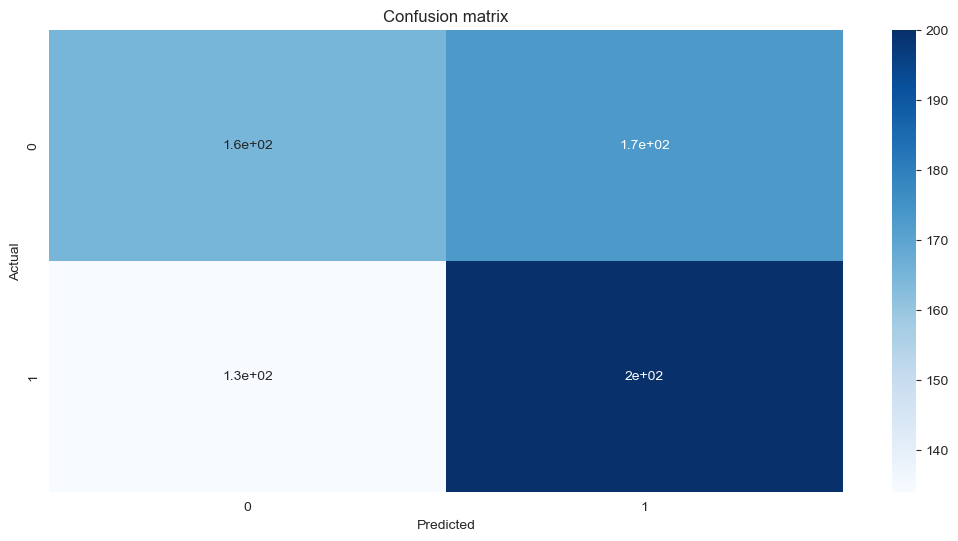

svm_fbcsp_with_MIBIF_pca12_channel
              precision    recall  f1-score   support

           0     0.5556    0.4586    0.5024       338
           1     0.5344    0.6287    0.5777       334

    accuracy                         0.5432       672
   macro avg     0.5450    0.5437    0.5401       672
weighted avg     0.5450    0.5432    0.5398       672



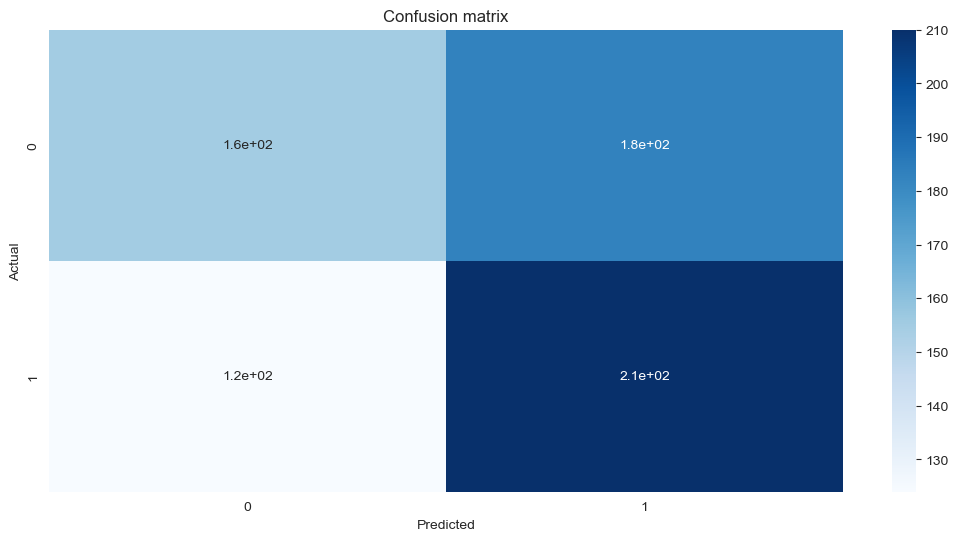

svm_fbcsp_with_pca10_pca12_channel
              precision    recall  f1-score   support

           0     0.5265    0.4408    0.4799       338
           1     0.5141    0.5988    0.5533       334

    accuracy                         0.5193       672
   macro avg     0.5203    0.5198    0.5166       672
weighted avg     0.5204    0.5193    0.5163       672



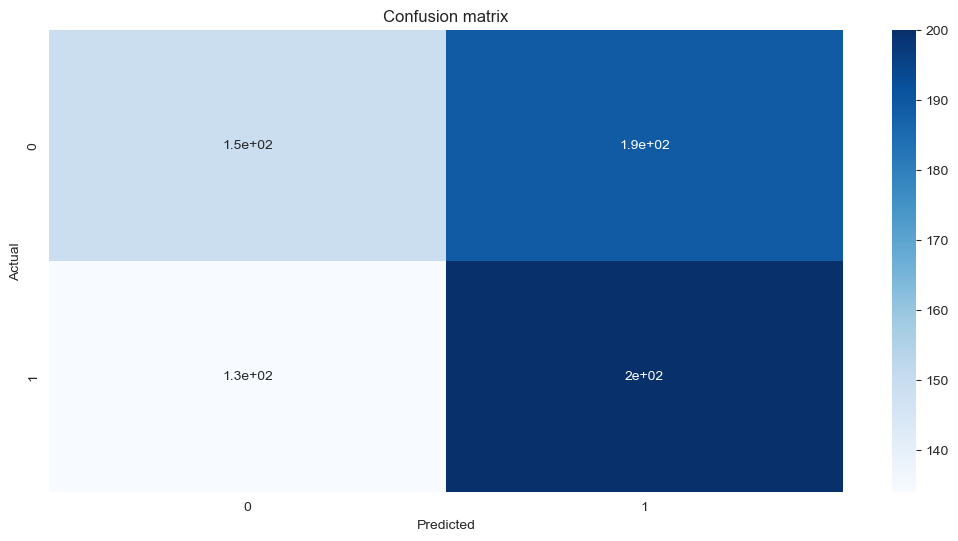

lda_csp4
              precision    recall  f1-score   support

           0     0.5839    0.2781    0.3768       338
           1     0.5225    0.7994    0.6320       334

    accuracy                         0.5372       672
   macro avg     0.5532    0.5388    0.5044       672
weighted avg     0.5534    0.5372    0.5036       672



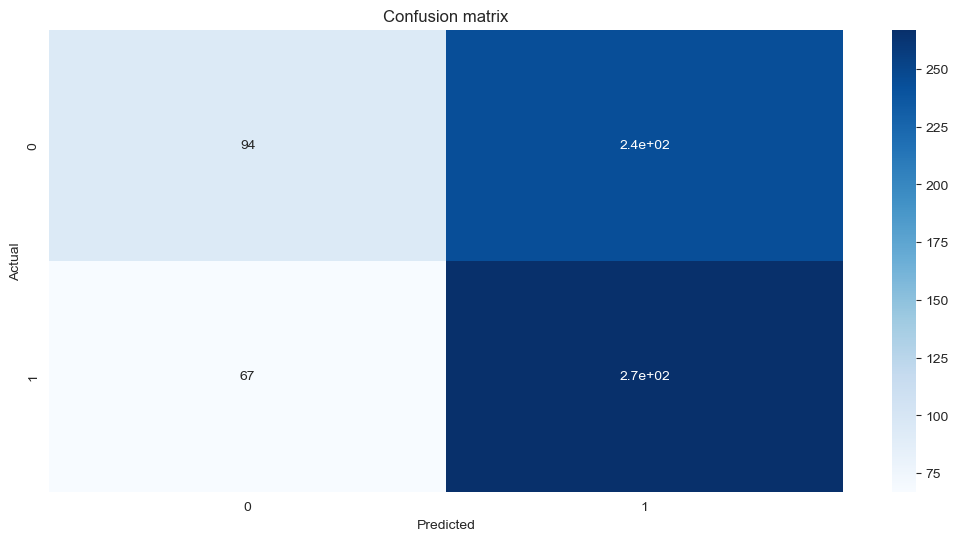

lda_csp15
              precision    recall  f1-score   support

           0     0.5867    0.2604    0.3607       338
           1     0.5211    0.8144    0.6355       334

    accuracy                         0.5357       672
   macro avg     0.5539    0.5374    0.4981       672
weighted avg     0.5541    0.5357    0.4973       672



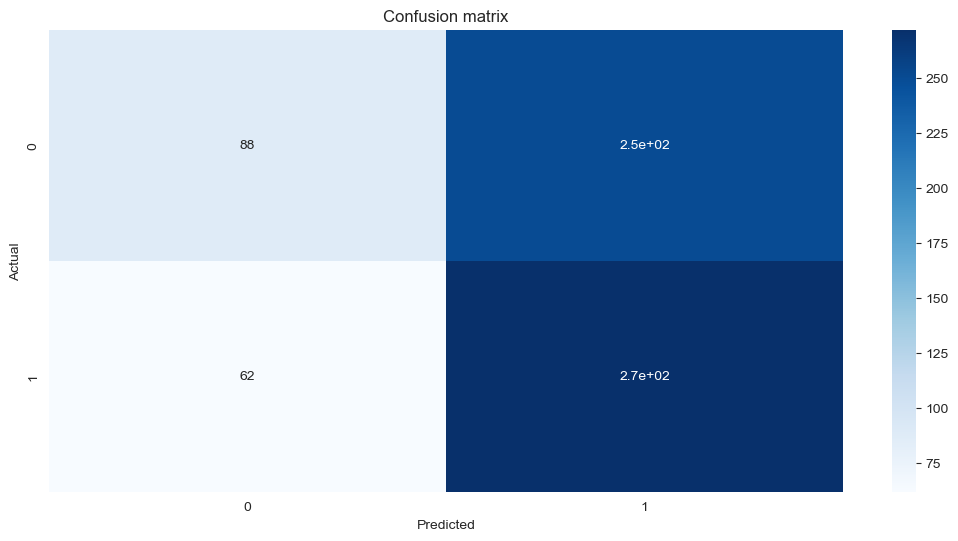

lda_pca12_channel_csp4
              precision    recall  f1-score   support

           0     0.5546    0.6006    0.5767       338
           1     0.5588    0.5120    0.5344       334

    accuracy                         0.5565       672
   macro avg     0.5567    0.5563    0.5555       672
weighted avg     0.5567    0.5565    0.5557       672



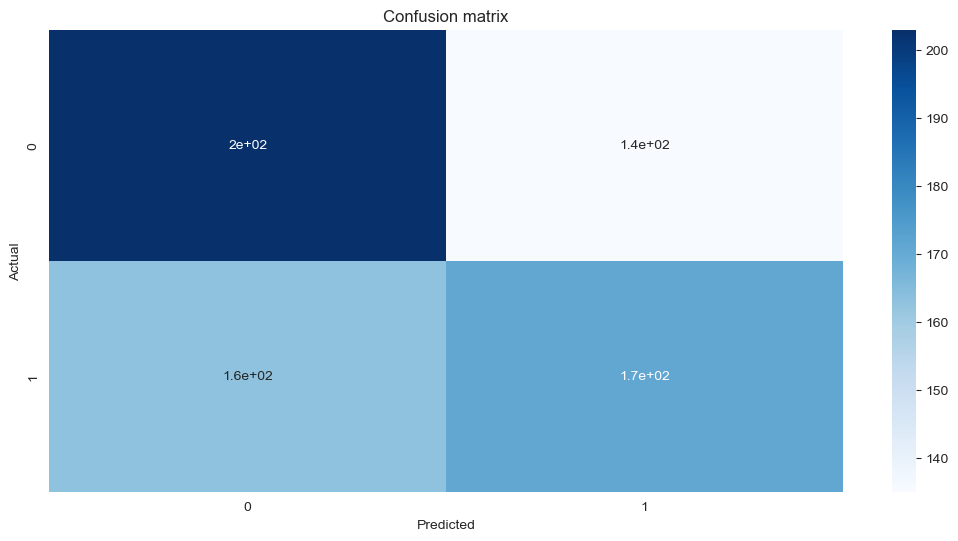

lda_pca12_channel
              precision    recall  f1-score   support

           0     0.5149    0.5118    0.5134       338
           1     0.5089    0.5120    0.5104       334

    accuracy                         0.5119       672
   macro avg     0.5119    0.5119    0.5119       672
weighted avg     0.5119    0.5119    0.5119       672



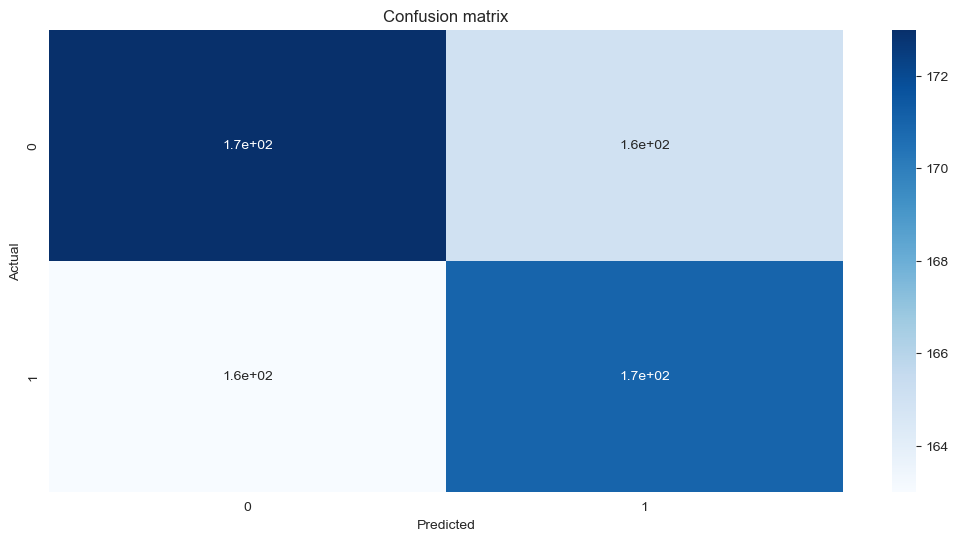

lda_pca12_channel_csp15
              precision    recall  f1-score   support

           0     0.5546    0.6006    0.5767       338
           1     0.5588    0.5120    0.5344       334

    accuracy                         0.5565       672
   macro avg     0.5567    0.5563    0.5555       672
weighted avg     0.5567    0.5565    0.5557       672



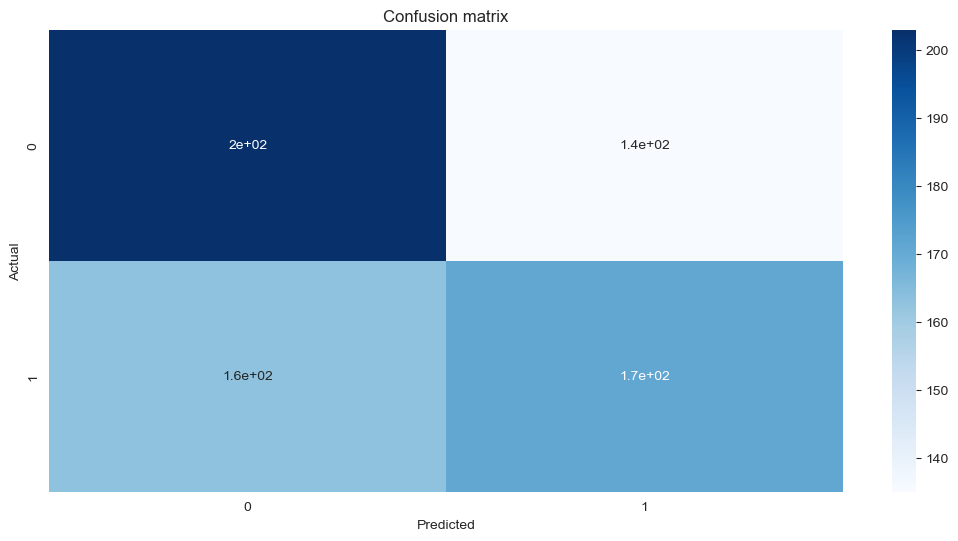

lda_fbcsp_with_pca10
              precision    recall  f1-score   support

           0     0.5746    0.3876    0.4629       338
           1     0.5338    0.7096    0.6093       334

    accuracy                         0.5476       672
   macro avg     0.5542    0.5486    0.5361       672
weighted avg     0.5543    0.5476    0.5356       672



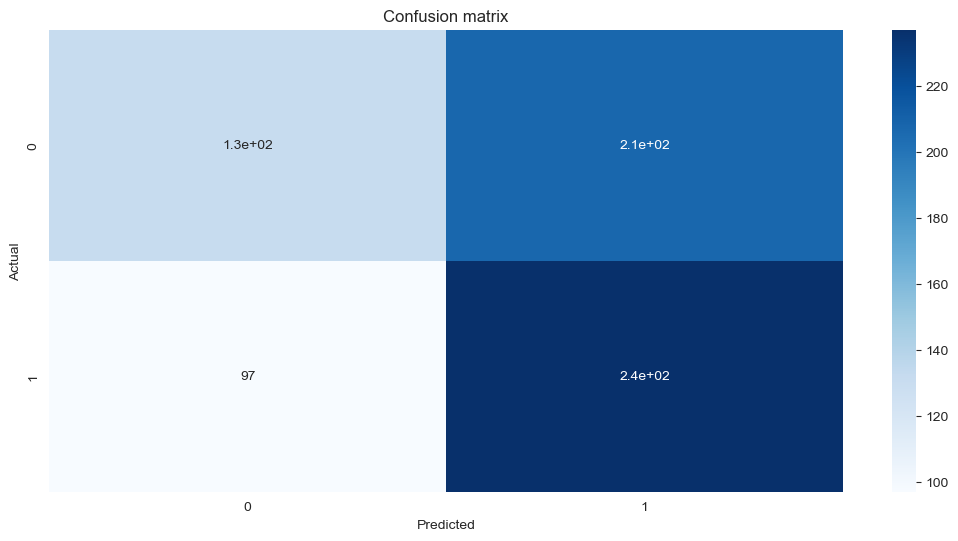

parzen_window_mnbc_with_MIBIF_fbcsp
              precision    recall  f1-score   support

           0     0.6667    0.2012    0.3091       338
           1     0.5263    0.8982    0.6637       334

    accuracy                         0.5476       672
   macro avg     0.5965    0.5497    0.4864       672
weighted avg     0.5969    0.5476    0.4853       672



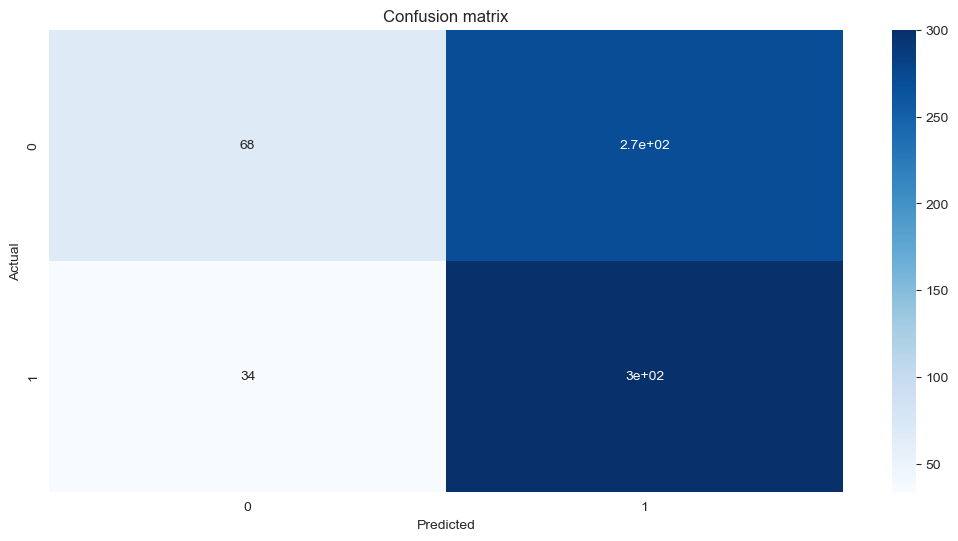

parzen_window_mnbc_without_MIBIF_fbcsp
              precision    recall  f1-score   support

           0     0.5030    1.0000    0.6693       338
           1     0.0000    0.0000    0.0000       334

    accuracy                         0.5030       672
   macro avg     0.2515    0.5000    0.3347       672
weighted avg     0.2530    0.5030    0.3366       672



d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defi

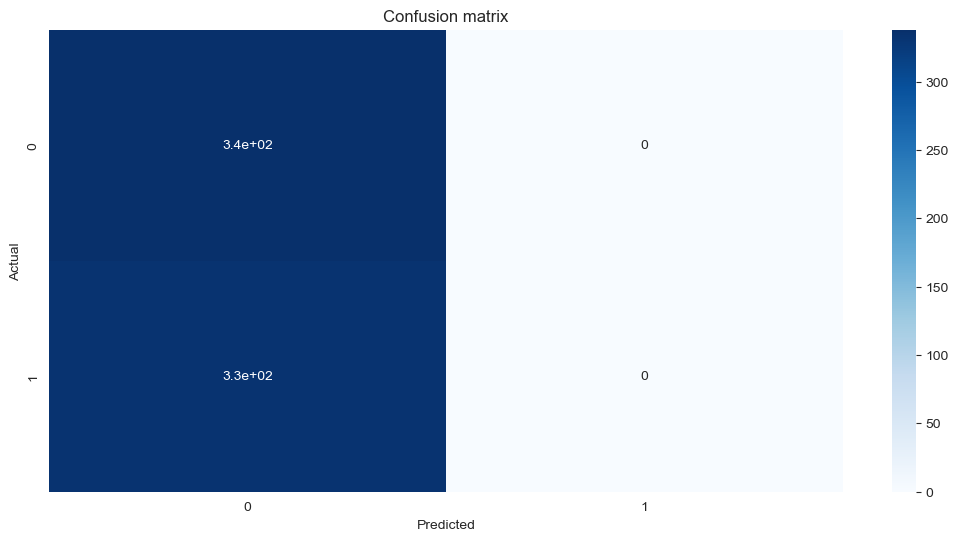

parzen_window_mnbc_without_MIBIF_csp4
              precision    recall  f1-score   support

           0     0.9524    0.0592    0.1114       338
           1     0.5115    0.9970    0.6761       334

    accuracy                         0.5253       672
   macro avg     0.7320    0.5281    0.3938       672
weighted avg     0.7333    0.5253    0.3921       672



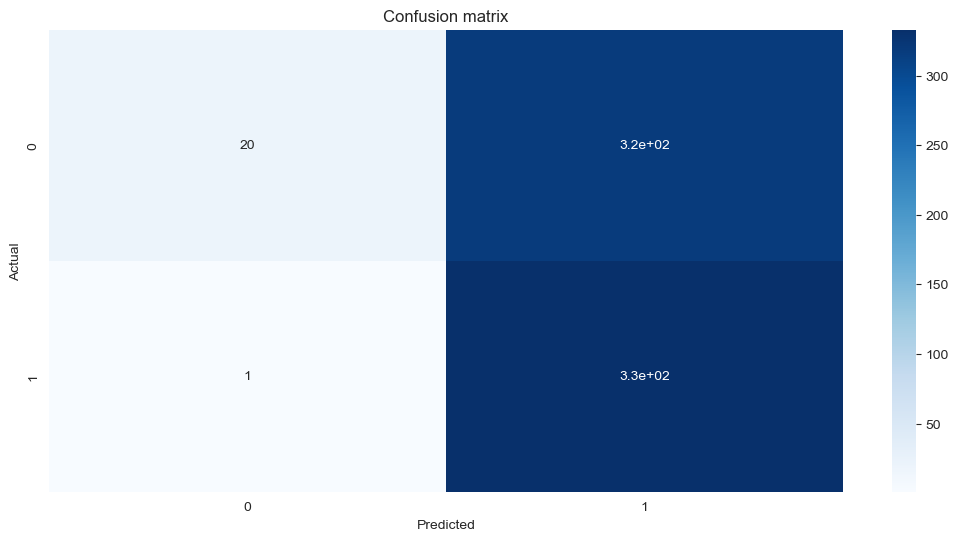

parzen_window_mnbc_without_MIBIF_csp15
              precision    recall  f1-score   support

           0     1.0000    0.0118    0.0234       338
           1     0.5000    1.0000    0.6667       334

    accuracy                         0.5030       672
   macro avg     0.7500    0.5059    0.3450       672
weighted avg     0.7515    0.5030    0.3431       672



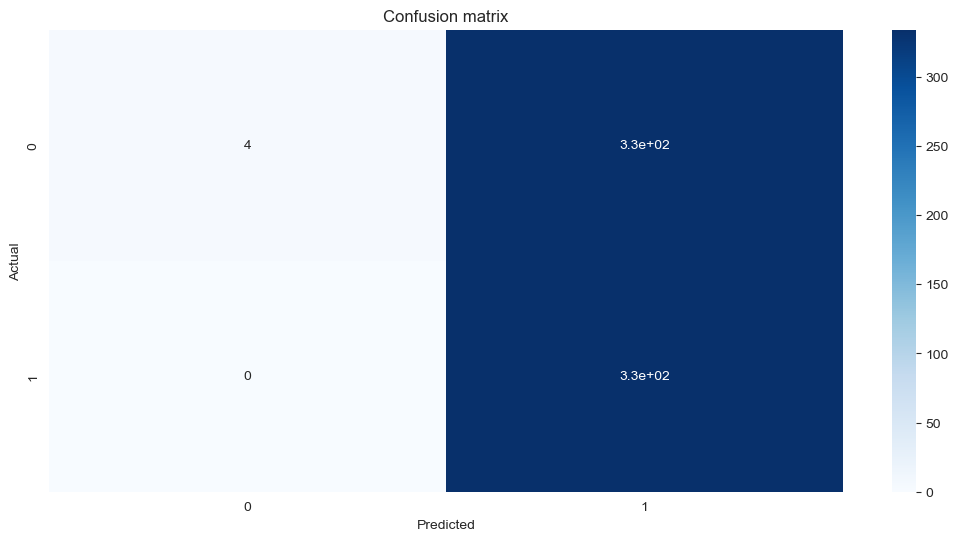

parzen_window_mnbc_without_MIBIF_pca12_channel


d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return summation / (N * (h ** dim))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defin

              precision    recall  f1-score   support

           0     0.5030    1.0000    0.6693       338
           1     0.0000    0.0000    0.0000       334

    accuracy                         0.5030       672
   macro avg     0.2515    0.5000    0.3347       672
weighted avg     0.2530    0.5030    0.3366       672



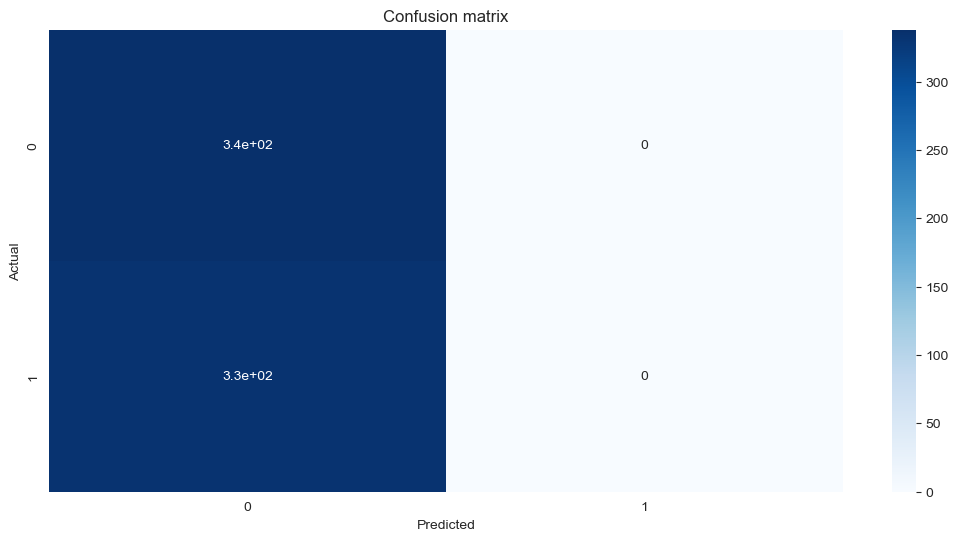

parzen_window_mnbc_without_MIBIF_pca12_channel_csp4
              precision    recall  f1-score   support

           0     0.6429    0.0266    0.0511       338
           1     0.5000    0.9850    0.6633       334

    accuracy                         0.5030       672
   macro avg     0.5714    0.5058    0.3572       672
weighted avg     0.5719    0.5030    0.3554       672



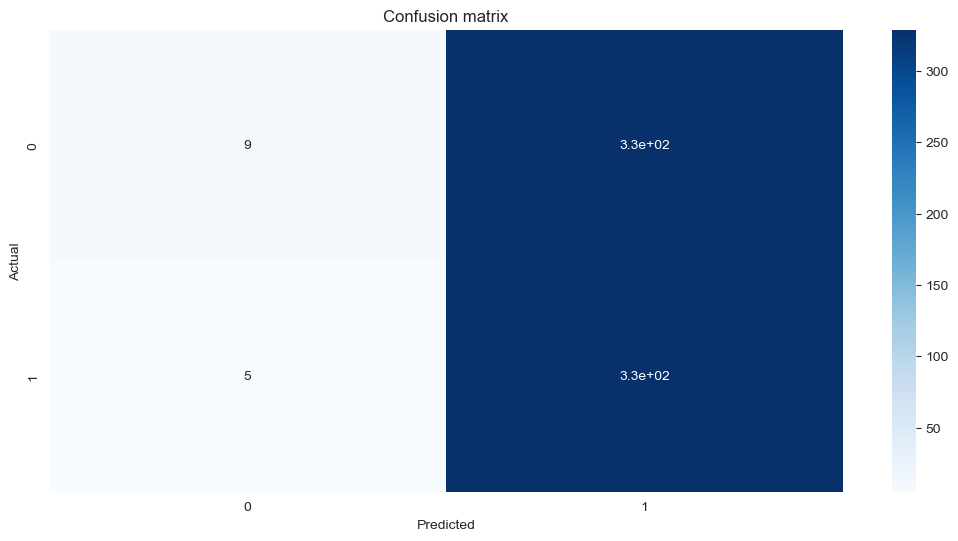

parzen_window_mnbc_without_MIBIF_pca12_channel_csp15
              precision    recall  f1-score   support

           0     0.6429    0.0266    0.0511       338
           1     0.5000    0.9850    0.6633       334

    accuracy                         0.5030       672
   macro avg     0.5714    0.5058    0.3572       672
weighted avg     0.5719    0.5030    0.3554       672



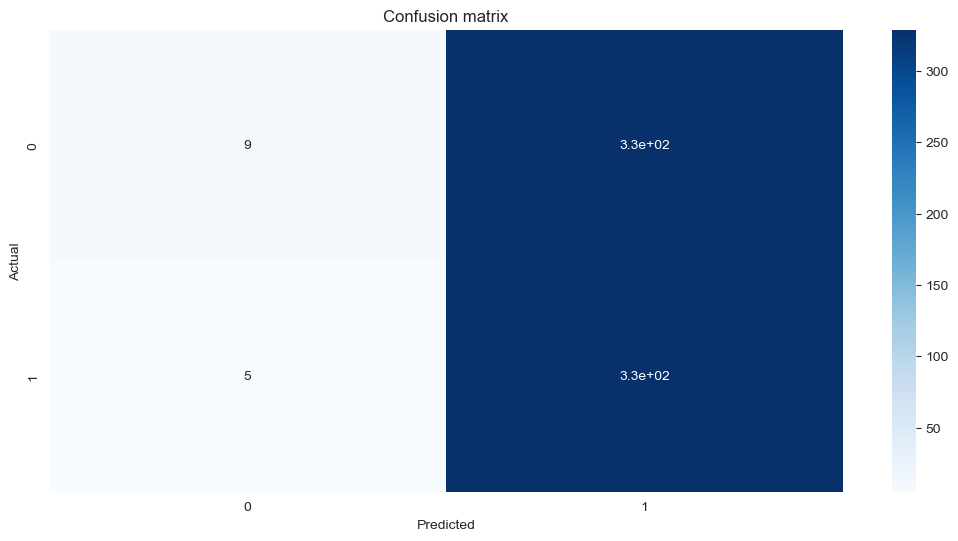

parzen_window_mnbc_fbcsp_with_pca10
              precision    recall  f1-score   support

           0     0.5446    0.1805    0.2711       338
           1     0.5054    0.8473    0.6331       334

    accuracy                         0.5119       672
   macro avg     0.5250    0.5139    0.4521       672
weighted avg     0.5251    0.5119    0.4510       672



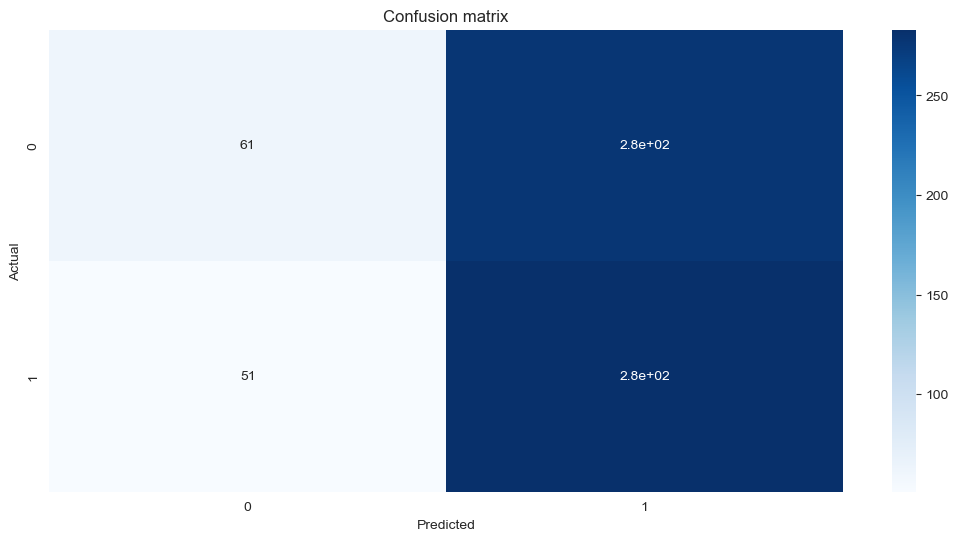

svm_fbcsp
              precision    recall  f1-score   support

           0     0.6049    0.3669    0.4567       338
           1     0.5418    0.7575    0.6317       334

    accuracy                         0.5610       672
   macro avg     0.5733    0.5622    0.5442       672
weighted avg     0.5735    0.5610    0.5437       672



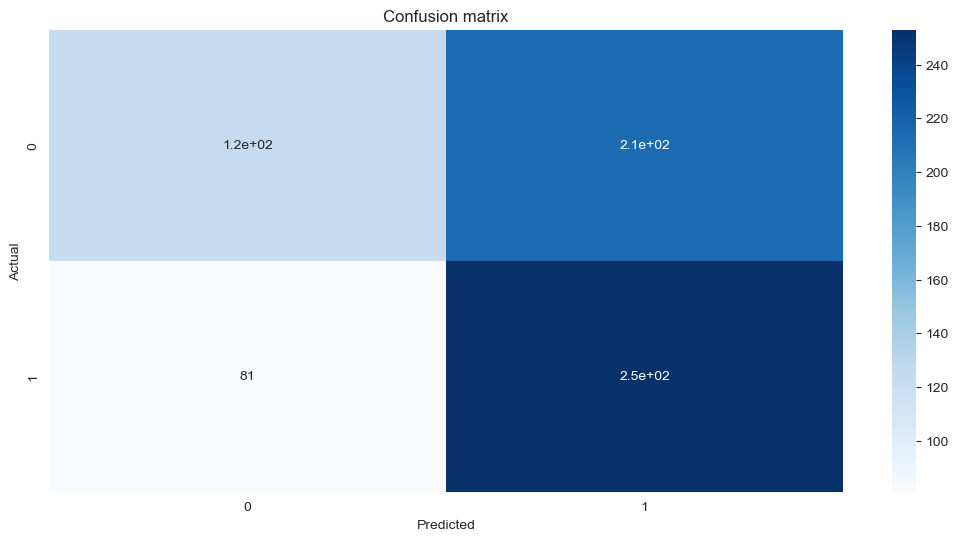

svm_fbcsp
              precision    recall  f1-score   support

           0     0.6126    0.4024    0.4857       338
           1     0.5511    0.7425    0.6327       334

    accuracy                         0.5714       672
   macro avg     0.5819    0.5724    0.5592       672
weighted avg     0.5820    0.5714    0.5587       672



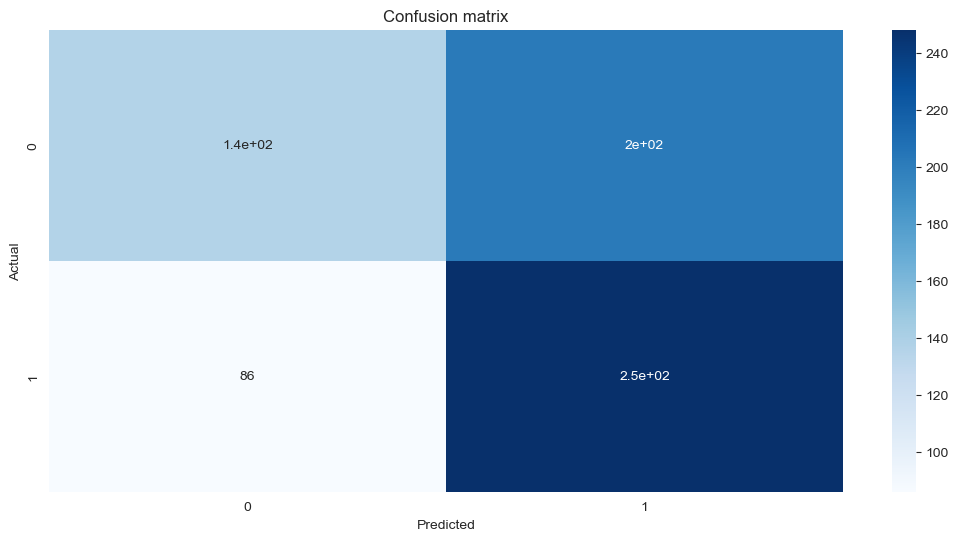

svm_csp4
              precision    recall  f1-score   support

           0     0.5586    0.2396    0.3354       338
           1     0.5123    0.8084    0.6272       334

    accuracy                         0.5223       672
   macro avg     0.5355    0.5240    0.4813       672
weighted avg     0.5356    0.5223    0.4804       672



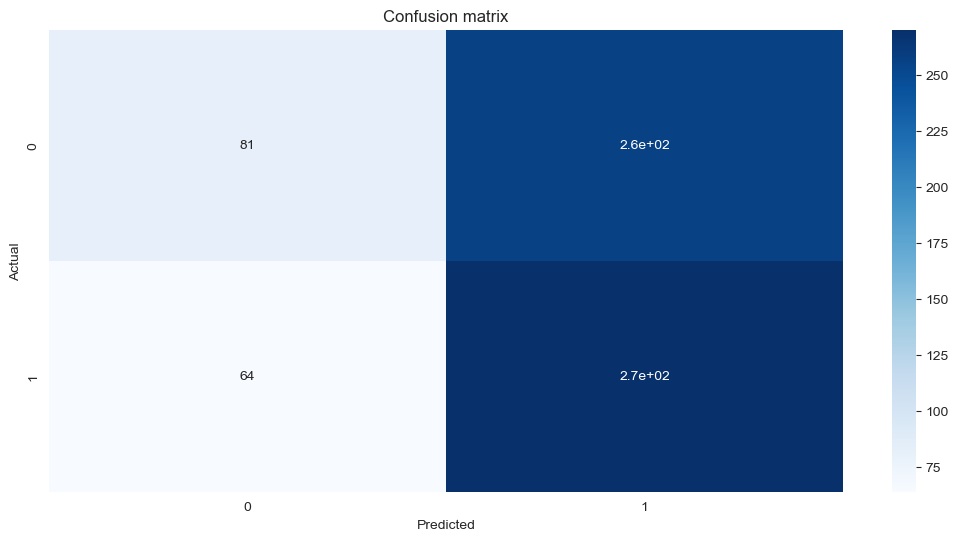

svm_csp15
              precision    recall  f1-score   support

           0     0.5899    0.2426    0.3438       338
           1     0.5197    0.8293    0.6390       334

    accuracy                         0.5342       672
   macro avg     0.5548    0.5360    0.4914       672
weighted avg     0.5550    0.5342    0.4905       672



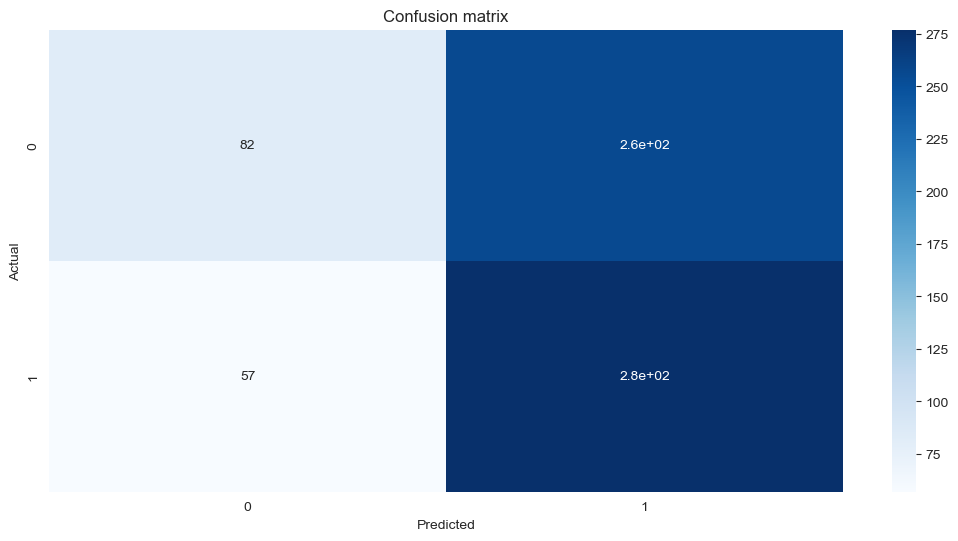

svm_pca12_channel_csp4
              precision    recall  f1-score   support

           0     0.5336    0.6805    0.5982       338
           1     0.5519    0.3982    0.4626       334

    accuracy                         0.5402       672
   macro avg     0.5428    0.5393    0.5304       672
weighted avg     0.5427    0.5402    0.5308       672



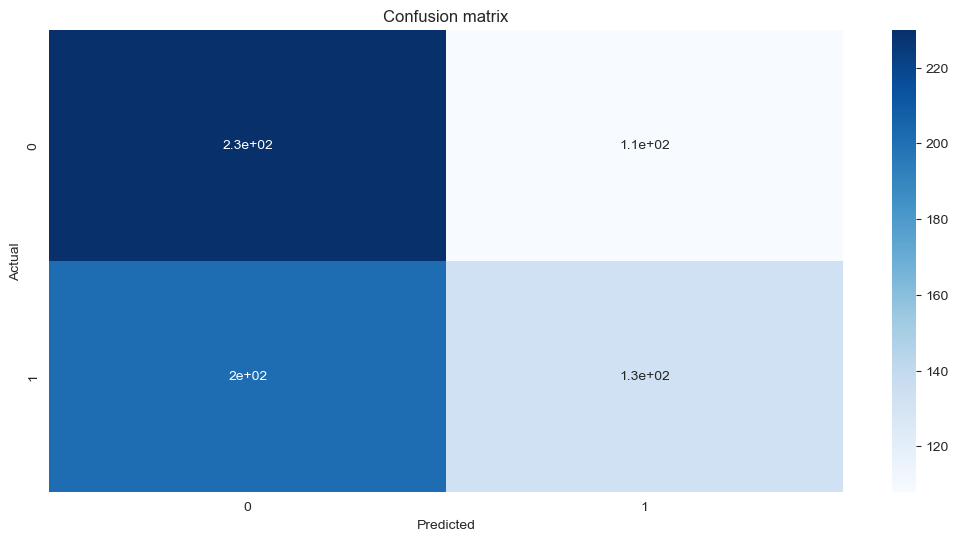

svm_pca12_channel
              precision    recall  f1-score   support

           0     0.5223    0.4497    0.4833       338
           1     0.5118    0.5838    0.5455       334

    accuracy                         0.5164       672
   macro avg     0.5171    0.5168    0.5144       672
weighted avg     0.5171    0.5164    0.5142       672



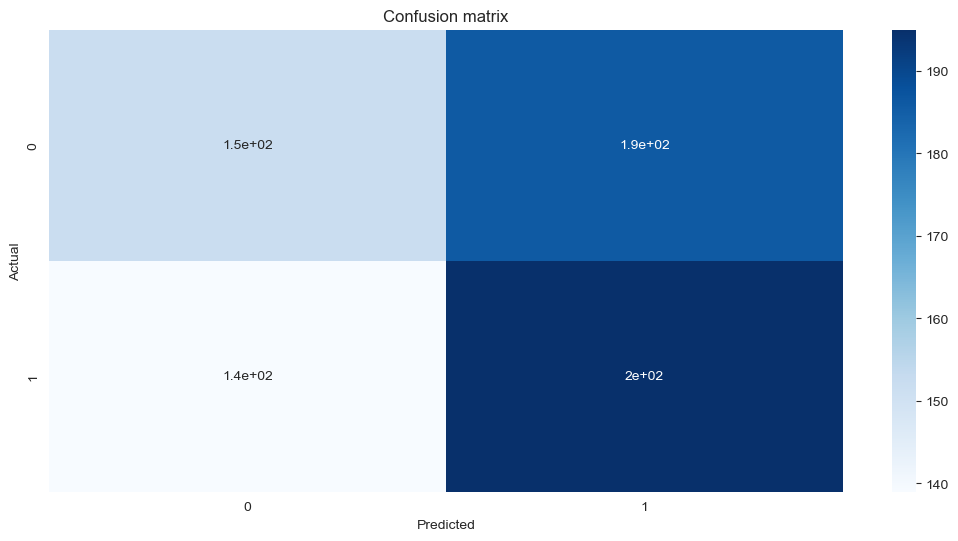

svm_pca12_channel_csp15
              precision    recall  f1-score   support

           0     0.5336    0.6805    0.5982       338
           1     0.5519    0.3982    0.4626       334

    accuracy                         0.5402       672
   macro avg     0.5428    0.5393    0.5304       672
weighted avg     0.5427    0.5402    0.5308       672



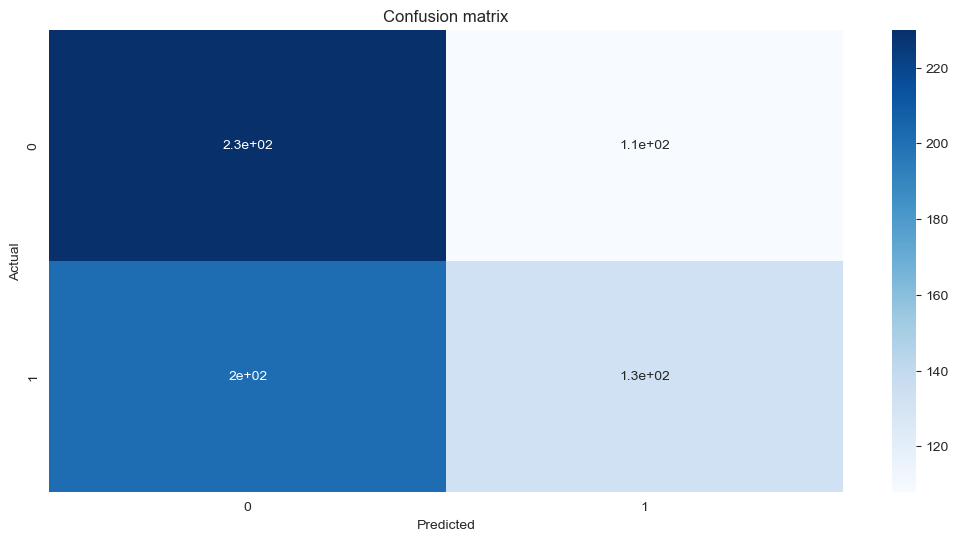

svm_fbcsp_with_pca10
              precision    recall  f1-score   support

           0     0.5751    0.3284    0.4181       338
           1     0.5261    0.7545    0.6199       334

    accuracy                         0.5402       672
   macro avg     0.5506    0.5414    0.5190       672
weighted avg     0.5508    0.5402    0.5184       672



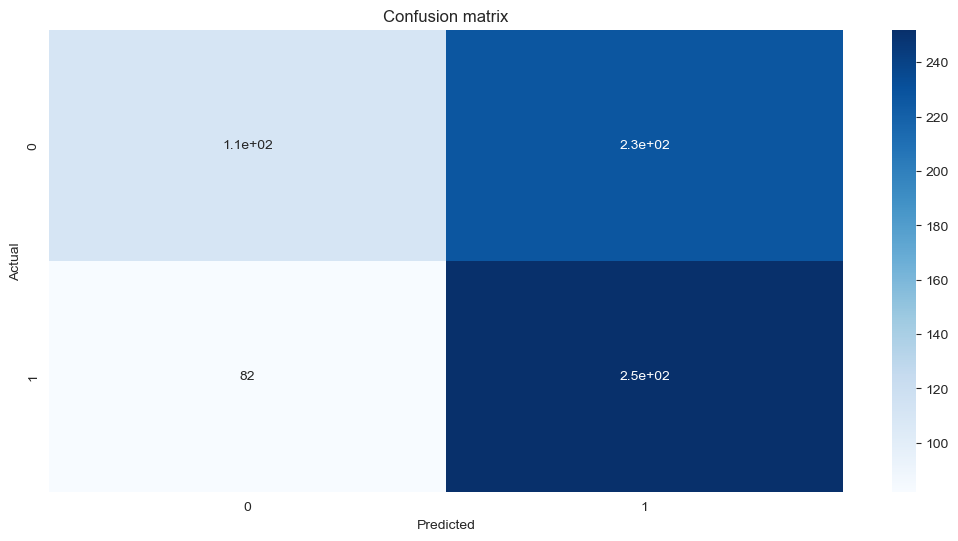

In [53]:
for pipe in Pipes:
    print(pipe.name)
    pipeline = pipe.create_pipeline()
    f1,acc = display_results(pd.DataFrame(y_val)[0],pipeline.predict(pipe.processed_X_val))


In [54]:
len(y_val)

672

In [55]:
np.sum(y_val)

334

In [56]:
1347-673

674

In [57]:
674/1347


0.5003711952487008

In [58]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

In [59]:
pipe.processed_X_val[:, n : (n + w_length)]

array([], shape=(672, 0), dtype=float64)

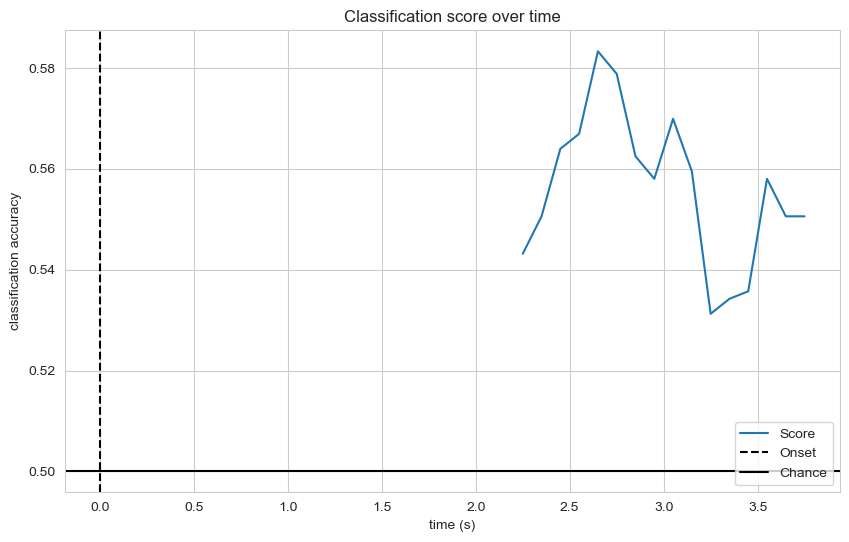

In [61]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_train.shape[2] - w_length, w_step)

scores_windows = []


# running classifier: test classifier on sliding window
score_this_window = []
for n in w_start:
    transform_list = []
    for event in X_val[:, :, n : (n + w_length)]:
        transform_list.append(pca12_channel.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    X_val_windoed_csp15 = pca12_channel_csp15.transform(transform_list.T)
    score_this_window.append(results_val["lda_pca12_channel_csp15"].score(X_val_windoed_csp15, y_val))
scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs_train.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# #Get Indices (it's the same for all, as suffle is False by default)
# pipe = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
# pipeline = pipe.create_pipeline()
# cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True,return_indices=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

# print(f"Results for pipeline with {pipe.name}:")
# print("----------------")
# print("Test accuracy scores:", cv_results['test_Accuracy'])
# print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
# print("-----")
# print("Test F1 scores:", cv_results['test_F1'])
# print("Mean test F1:", cv_results['test_F1'].mean())
# print("----------------")
# print("train accuracy scores:", cv_results['train_Accuracy'])
# print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
# print("-----")
# print("train F1 scores:", cv_results['train_F1'])
# print("Mean train F1:", cv_results['train_F1'].mean())
# print("----------------")
# print("Fit time:", cv_results['fit_time'])
# print("Score time:", cv_results['score_time'])
# print()
# print("--------------------------------------------------------------------------------------------")

# indices = cv_results["indices"]["test"]

In [ ]:
# def aff(array):
#     X_std = (array - np.min(array)) / (np.max(array) - np.min(array))
#     X_scaled = X_std * (1-0)+0
#     return X_scaled

In [ ]:
# # lda_plain = Pipe("lda_csp4",LinearDiscriminantAnalysis(),concat_channels("X_train") ) - Takes too long
# lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
# lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
# lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# lda_pca16_data_csp4 = Pipe("lda_pca16_data_csp4",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# # lda_pca900_all = Pipe("lda_pca900_all",LinearDiscriminantAnalysis(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
# lda_pca12_channel = Pipe("lda_pca12_channel",LinearDiscriminantAnalysis(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# lda_pca16_data = Pipe("lda_pca16_data",LinearDiscriminantAnalysis(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# lda_pca12_channel_csp15 = Pipe("lda_pca12_channel_csp15",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
# lda_pca16_data_csp15 = Pipe("lda_pca16_data_csp15",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# # mnbc_plain = Pipe("mnbc_plain",MultinomialNB(),concat_channels("X_train"),aff)
# mnbc_csp4 = Pipe("mnbc_csp4",MultinomialNB(),transform_csp("X_train",csp4),transform_csp("X_val",csp4),aff)
# mnbc_csp15 = Pipe("mnbc_csp15",MultinomialNB(),transform_csp("X_train",csp15),transform_csp("X_val",csp15),aff)
# mnbc_pca12_channel = Pipe("mnbc_pca12_channel",MultinomialNB(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel),aff)
# mnbc_pca16_data = Pipe("mnbc_pca16_data",MultinomialNB(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data),aff)
# # # # # mnbc_pca900_all = Pipe("mnbc_pca900_all",MultinomialNB(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all),aff)
# mnbc_pca12_channel_csp4 = Pipe("mnbc_pca12_channel_csp4",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4),aff)
# mnbc_pca16_data_csp4 = Pipe("mnbc_pca16_data_csp4",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4),aff)
# mnbc_pca12_channel_csp15 = Pipe("mnbc_pca12_channel_csp15",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15),aff)
# mnbc_pca16_data_csp15 = Pipe("mnbc_pca16_data_csp15",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15),aff)
# # MLP_plain = Pipe("MLP_plain",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),concat_channels("X_train")) - Takes too long
# MLP_csp4 = Pipe("MLP_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
# MLP_csp15 = Pipe("MLP_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
# MLP_pca12_channel = Pipe("MLP_pca12_channel",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# MLP_pca16_data = Pipe("MLP_pca16_data",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # # # MLP_pca900_all = Pipe("MLP_pca900_all",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
# MLP_pca12_channel_csp4 = Pipe("MLP_pca12_channel_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# MLP_pca16_data_csp4 = Pipe("MLP_pca16_data_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# MLP_pca12_channel_csp15 = Pipe("MLP_pca12_channel_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
# MLP_pca16_data_csp15 = Pipe("MLP_pca16_data_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# Keras_MLP_csp4 = Pipe("Keras_MLP_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp4).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
# Keras_MLP_csp15 = Pipe("Keras_MLP_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp15).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp15),transform_csp("X_val",csp15))

# Keras_MLP_pca12_channel = Pipe("Keras_MLP_pca12_channel",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_concat("X_train",pca12_channel).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# Keras_MLP_pca16_data = Pipe("Keras_MLP_pca16_data",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_concat("X_train",pca16_data).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # Keras_MLP_pca900_all = Pipe("Keras_MLP_pca900_all",KerasClassifier(model=create_model, my_params={
#         # "layers":[
#         #     # tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_all_concat("X_train",pca900_all).shape[1],)),
#         #     tf.keras.layers.Dense(20, activation='sigmoid'),
#         #     tf.keras.layers.Dropout(0.5,seed= 42),
#         #     tf.keras.layers.Dense(20, activation='sigmoid'),
#         #     tf.keras.layers.Dropout(0.5,seed= 42),
#         #     tf.keras.layers.Dense(10, activation='sigmoid'),
#         #     tf.keras.layers.Dense(5, activation='sigmoid'),
#         #     tf.keras.layers.Dense(3, activation='softmax')
#         # ],
#         # "optimizer":'adam',
#         # "loss": 'sparse_categorical_crossentropy',
#         # "metrics": ['accuracy']
#     # # }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))



# Keras_MLP_pca16_data_csp4 = Pipe("Keras_MLP_pca16_data_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# Keras_MLP_pca12_channel_csp4 = Pipe("Keras_MLP_pca12_channel_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# Keras_MLP_pca16_data_csp15 = Pipe("Keras_MLP_pca16_data_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# Keras_MLP_pca12_channel_csp15 = Pipe("Keras_MLP_pca12_channel_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))




# Pipes = [
#     lda_csp4,
#     lda_csp15,
#     lda_pca12_channel_csp4,
#     lda_pca16_data_csp4,
#     # lda_pca900_all,
#     lda_pca12_channel,
#     lda_pca16_data,
#     lda_pca12_channel_csp15,
#     lda_pca16_data_csp15,
#     # mnbc_plain,
#     mnbc_csp4,
#     mnbc_csp15,
#     mnbc_pca12_channel,
#     mnbc_pca16_data,
#     # mnbc_pca900_all,
#     mnbc_pca12_channel_csp4,
#     mnbc_pca16_data_csp4,
#     mnbc_pca12_channel_csp15,
#     mnbc_pca16_data_csp15,
#     # MLP_plain,
#     MLP_csp4,
#     MLP_csp15,
#     MLP_pca12_channel,
#     MLP_pca16_data,
#     # MLP_pca900_all,
#     MLP_pca12_channel_csp4,
#     MLP_pca16_data_csp4,
#     MLP_pca12_channel_csp15,
#     MLP_pca16_data_csp15,
#     Keras_MLP_csp4,
#     Keras_MLP_csp15,
#     Keras_MLP_pca12_channel,
#     Keras_MLP_pca16_data,
#     # Keras_MLP_pca900_all,
#     Keras_MLP_pca16_data_csp4,
#     Keras_MLP_pca12_channel_csp4,
#     Keras_MLP_pca16_data_csp15,
#     Keras_MLP_pca12_channel_csp15,
    
    
    
# ]


In [ ]:
# results = {}
# for pipe in Pipes:
#     print(pipe.name)
#     # Create pipeline with the given pipe
#     pipeline = pipe.create_pipeline()
    
#     # Perform cross-validation
#     cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

#     print(f"Results for pipeline with {pipe.name}:")
#     print("----------------")
#     print("Test accuracy scores:", cv_results['test_Accuracy'])
#     print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
#     print("-----")
#     print("Test F1 scores:", cv_results['test_F1'])
#     print("Mean test F1:", cv_results['test_F1'].mean())
#     print("----------------")
#     print("train accuracy scores:", cv_results['train_Accuracy'])
#     print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
#     print("-----")
#     print("train F1 scores:", cv_results['train_F1'])
#     print("Mean train F1:", cv_results['train_F1'].mean())
#     print("----------------")
#     print("Fit time:", cv_results['fit_time'])
#     print("Score time:", cv_results['score_time'])
#     print()
#     print("--------------------------------------------------------------------------------------------")

#     results[pipe.name] = (cv_results)


In [ ]:
# for key, value in results.items(): 
#     print(value['test_Accuracy'])
#     print(",")
# for key, value in results.items(): 
#     print(np.mean(value['test_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(np.max(value['test_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(value['test_F1'])
#     print(",")
# for key, value in results.items(): 
#     print(value['train_Accuracy'])
#     print(",")
# for key, value in results.items(): 
#     print(np.mean(value['train_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(np.max(value['train_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(value['train_F1'])
#     print(",")
# for key, value in results.items(): 
#     print(value['fit_time'])
#     print(",")
# for key, value in results.items(): 
#     print(value['score_time'])
#     print(",")

In [ ]:
# # lda_plain = Pipe("lda_csp4",LinearDiscriminantAnalysis(),concat_channels("X_train") ) - Takes too long
# lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
# lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
# lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# lda_pca16_data_csp4 = Pipe("lda_pca16_data_csp4",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# # lda_pca900_all = Pipe("lda_pca900_all",LinearDiscriminantAnalysis(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
# lda_pca12_channel = Pipe("lda_pca12_channel",LinearDiscriminantAnalysis(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# lda_pca16_data = Pipe("lda_pca16_data",LinearDiscriminantAnalysis(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# lda_pca12_channel_csp15 = Pipe("lda_pca12_channel_csp15",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
# lda_pca16_data_csp15 = Pipe("lda_pca16_data_csp15",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# # mnbc_plain = Pipe("mnbc_plain",MultinomialNB(),concat_channels("X_train"),aff)
# mnbc_csp4 = Pipe("mnbc_csp4",MultinomialNB(),transform_csp("X_train",csp4),transform_csp("X_val",csp4),aff)
# mnbc_csp15 = Pipe("mnbc_csp15",MultinomialNB(),transform_csp("X_train",csp15),transform_csp("X_val",csp15),aff)
# mnbc_pca12_channel = Pipe("mnbc_pca12_channel",MultinomialNB(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel),aff)
# mnbc_pca16_data = Pipe("mnbc_pca16_data",MultinomialNB(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data),aff)
# # # mnbc_pca900_all = Pipe("mnbc_pca900_all",MultinomialNB(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all),aff)
# mnbc_pca12_channel_csp4 = Pipe("mnbc_pca12_channel_csp4",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4),aff)
# mnbc_pca16_data_csp4 = Pipe("mnbc_pca16_data_csp4",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4),aff)
# mnbc_pca12_channel_csp15 = Pipe("mnbc_pca12_channel_csp15",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15),aff)
# mnbc_pca16_data_csp15 = Pipe("mnbc_pca16_data_csp15",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15),aff)
# # MLP_plain = Pipe("MLP_plain",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),concat_channels("X_train")) - Takes too long
# MLP_csp4 = Pipe("MLP_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
# MLP_csp15 = Pipe("MLP_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
# MLP_pca12_channel = Pipe("MLP_pca12_channel",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# MLP_pca16_data = Pipe("MLP_pca16_data",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # MLP_pca900_all = Pipe("MLP_pca900_all",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
# MLP_pca12_channel_csp4 = Pipe("MLP_pca12_channel_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# MLP_pca16_data_csp4 = Pipe("MLP_pca16_data_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# MLP_pca12_channel_csp15 = Pipe("MLP_pca12_channel_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
# MLP_pca16_data_csp15 = Pipe("MLP_pca16_data_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# Keras_MLP_csp4 = Pipe("Keras_MLP_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(8, activation='sigmoid', input_shape=(transform_csp("X_train",csp4).shape[1],)),
#             tf.keras.layers.Dense(4, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=400, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
# Keras_MLP_csp15 = Pipe("Keras_MLP_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(8, activation='sigmoid', input_shape=(transform_csp("X_train",csp15).shape[1],)),
#             tf.keras.layers.Dense(4, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=400, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp15),transform_csp("X_val",csp15))

# Keras_MLP_pca12_channel = Pipe("Keras_MLP_pca12_channel",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(8, activation='sigmoid', input_shape=(transform_channel_concat("X_train",pca12_channel).shape[1],)),
#             tf.keras.layers.Dense(4, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=400, batch_size=32, verbose=0,random_state=42),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# Keras_MLP_pca16_data = Pipe("Keras_MLP_pca16_data",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(8, activation='sigmoid', input_shape=(transform_data_concat("X_train",pca16_data).shape[1],)),
#             tf.keras.layers.Dense(4, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=400, batch_size=32, verbose=0,random_state=42),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # Keras_MLP_pca900_all = Pipe("Keras_MLP_pca900_all",KerasClassifier(model=create_model, my_params={
# #         "layers":[
# #             tf.keras.layers.Dense(8, activation='sigmoid', input_shape=(transform_all_concat("X_train",pca900_all).shape[1],)),
# #             tf.keras.layers.Dense(4, activation='sigmoid'),
# #             tf.keras.layers.Dense(3, activation='softmax')
# #         ],
# #         "optimizer":'adam',
# #         "loss": 'sparse_categorical_crossentropy',
# #         "metrics": ['accuracy']
# #     # }, epochs=400, batch_size=32, verbose=0,random_state=42),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))



# Keras_MLP_pca16_data_csp4 = Pipe("Keras_MLP_pca16_data_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(8, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4).shape[1],)),
#             tf.keras.layers.Dense(4, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=400, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# Keras_MLP_pca12_channel_csp4 = Pipe("Keras_MLP_pca12_channel_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(8, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4).shape[1],)),
#             tf.keras.layers.Dense(4, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=400, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# Keras_MLP_pca16_data_csp15 = Pipe("Keras_MLP_pca16_data_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(8, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15).shape[1],)),
#             tf.keras.layers.Dense(4, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=400, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# Keras_MLP_pca12_channel_csp15 = Pipe("Keras_MLP_pca12_channel_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(8, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1],)),
#             tf.keras.layers.Dense(4, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=400, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))




# Pipes = [
#     lda_csp4,
#     lda_csp15,
#     lda_pca12_channel_csp4,
#     lda_pca12_channel_csp15,
#     lda_pca16_data_csp4,
#     lda_pca16_data_csp15,
#     # mnbc_plain,
#     mnbc_csp4,
#     mnbc_csp15,
#     mnbc_pca12_channel_csp4,
#     mnbc_pca12_channel_csp15,
#     mnbc_pca16_data_csp4,
#     mnbc_pca16_data_csp15,
#     # MLP_plain,
#     MLP_csp4,
#     MLP_csp15,
#     MLP_pca12_channel_csp4,
#     MLP_pca12_channel_csp15,
#     MLP_pca16_data_csp4,
#     MLP_pca16_data_csp15,

#     Keras_MLP_csp4,
#     Keras_MLP_csp15,
#     Keras_MLP_pca12_channel_csp4,
#     Keras_MLP_pca12_channel_csp15,
#     Keras_MLP_pca16_data_csp4,
#     Keras_MLP_pca16_data_csp15,
    
#     lda_pca12_channel,
#     lda_pca16_data,
#     # lda_pca900_all,
#     mnbc_pca12_channel,
#     mnbc_pca16_data,
#     # mnbc_pca900_all,
#     MLP_pca12_channel,
#     MLP_pca16_data,
#     # MLP_pca900_all,
#     Keras_MLP_pca12_channel,
#     Keras_MLP_pca16_data,
#     # Keras_MLP_pca900_all,
    
    
# ]


In [ ]:
# results_val = {}
# for pipe in Pipes:
#     print(pipe.name)
#     # Create pipeline with the given pipe
#     pipeline = pipe.create_pipeline()
    
#     # Perform cross-validation
#     pipeline.fit( pipe.processed_X_train, y_train)
#     train_score = pipeline.score(pipe.processed_X_train,y_train)
#     val_score = pipeline.score(pipe.processed_X_val,y_val)


#     print(f"Results for pipeline with {pipe.name}:")
#     print("----------------")
#     print("Test accuracy scores:", val_score)
#     print("----------------")
#     print("train accuracy scores:", train_score)
#     print()
#     print("--------------------------------------------------------------------------------------------")

#     results_val[pipe.name] = (pipeline)


In [ ]:

# for pipe in Pipes:
#     print(pipe.name)
#     pipeline = pipe.create_pipeline()
#     f1,acc = display_results(pd.DataFrame(y_val)[0],pipeline.predict(pipe.processed_X_val))


In [ ]:
# sfreq = raw.info["sfreq"]
# w_length = int(sfreq * 0.5)  # running classifier: window length
# w_step = int(sfreq * 0.1)  # running classifier: window step size
# w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

In [ ]:
# pipe.processed_X_val[:, n : (n + w_length)]

In [ ]:
# sfreq = raw.info["sfreq"]
# w_length = int(sfreq * 0.5)  # running classifier: window length
# w_step = int(sfreq * 0.1)  # running classifier: window step size
# w_start = np.arange(0, epochs_data_train.shape[2] - w_length, w_step)

# scores_windows = []


# # running classifier: test classifier on sliding window
# score_this_window = []
# for n in w_start:
#     transform_list = []
#     for event in X_val[:, :, n : (n + w_length)]:
#         transform_list.append(pca12_channel.transform(event.T))
#     transform_list = np.stack(transform_list, axis=2) 
#     X_val_windoed_csp15 = pca12_channel_csp15.transform(transform_list.T)
#     score_this_window.append(results_val["lda_pca12_channel_csp15"].score(X_val_windoed_csp15, y_val))
# scores_windows.append(score_this_window)

# # Plot scores over time
# w_times = (w_start + w_length / 2.0) / sfreq + epochs_train.tmin

# plt.figure()
# plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
# plt.axvline(0, linestyle="--", color="k", label="Onset")
# plt.axhline(0.5, linestyle="-", color="k", label="Chance")
# plt.xlabel("time (s)")
# plt.ylabel("classification accuracy")
# plt.title("Classification score over time")
# plt.legend(loc="lower right")
# plt.show()